=== Metrics ===
MAE: 1652.46
MSE: 4638844.06
RMSE: 2153.80
R²: 0.64


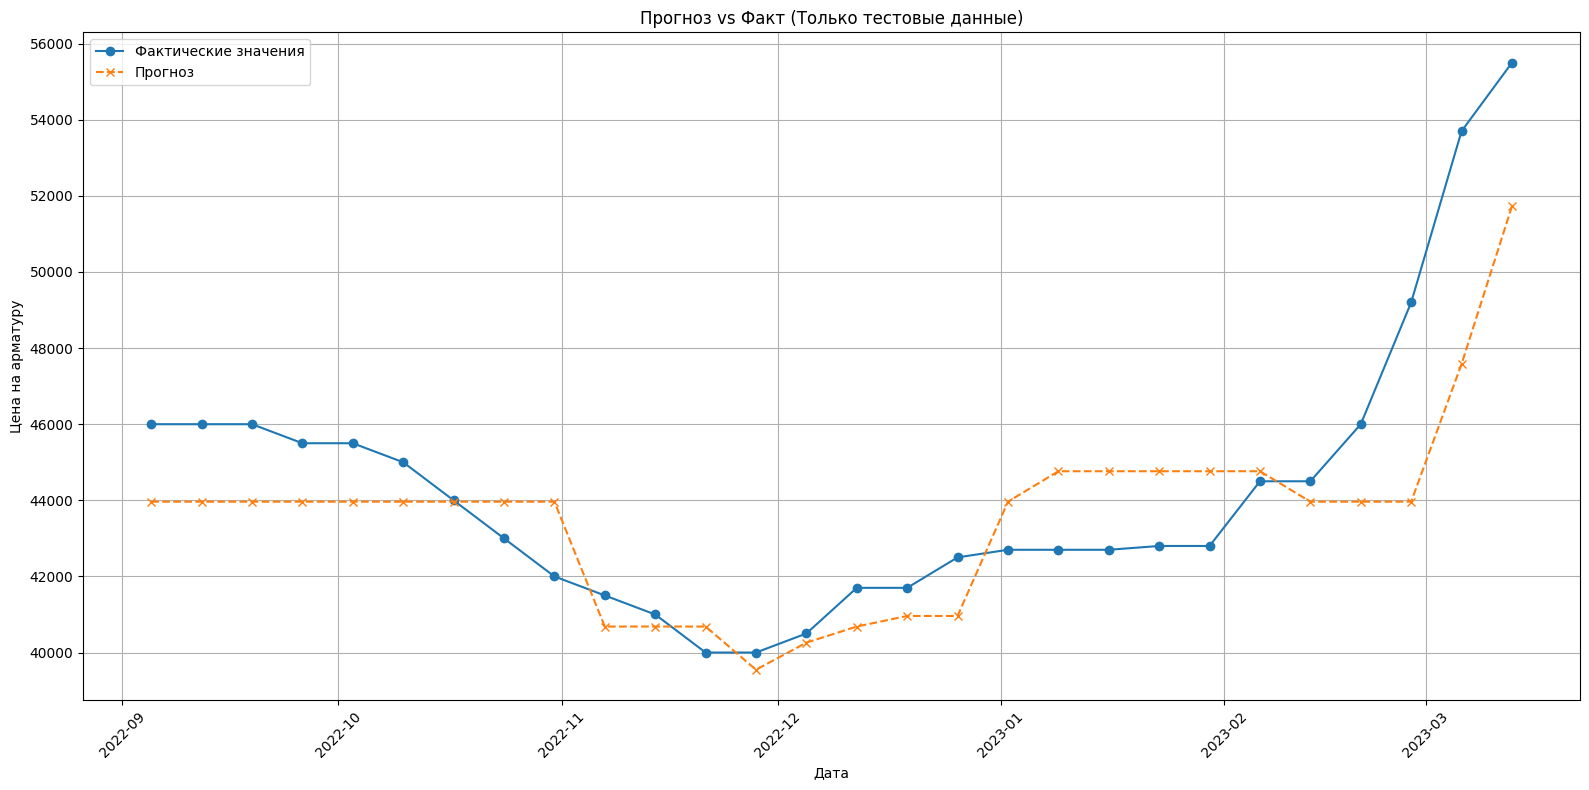

=== Train Metrics ===

Train:
MAE: 1760.96
MSE: 12132699.04
RMSE: 3483.20
R²: 0.93

=== Test Metrics ===

Test:
MAE: 1593.01
MSE: 4439303.88
RMSE: 2106.97
R²: 0.65


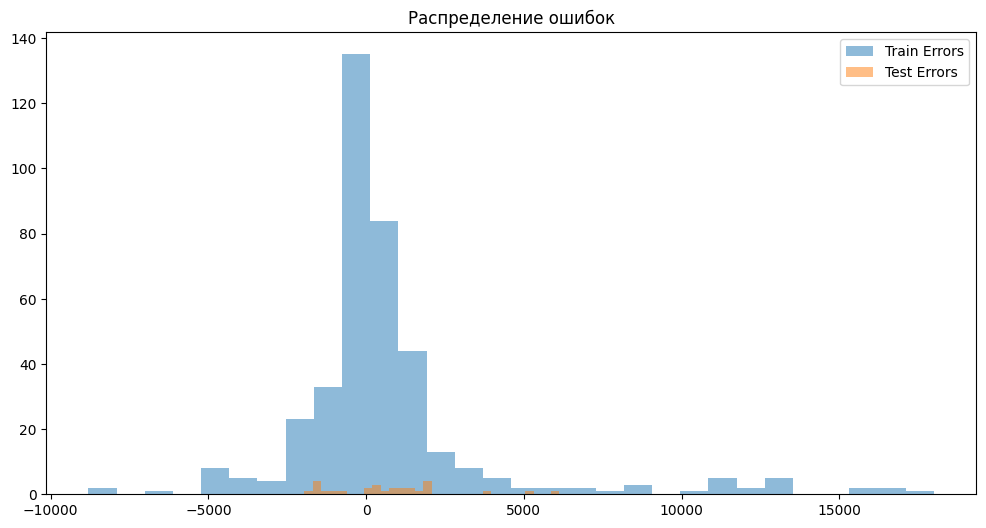


=== Cross-Validation Scores ===
Средний R²: -0.68
Стандартное отклонение R²: 1.44
Все оценки: [-2.699929272024075, 0.5129966567527859, 0.764376474895285, 0.13374443194002517, -2.1182349846644204]


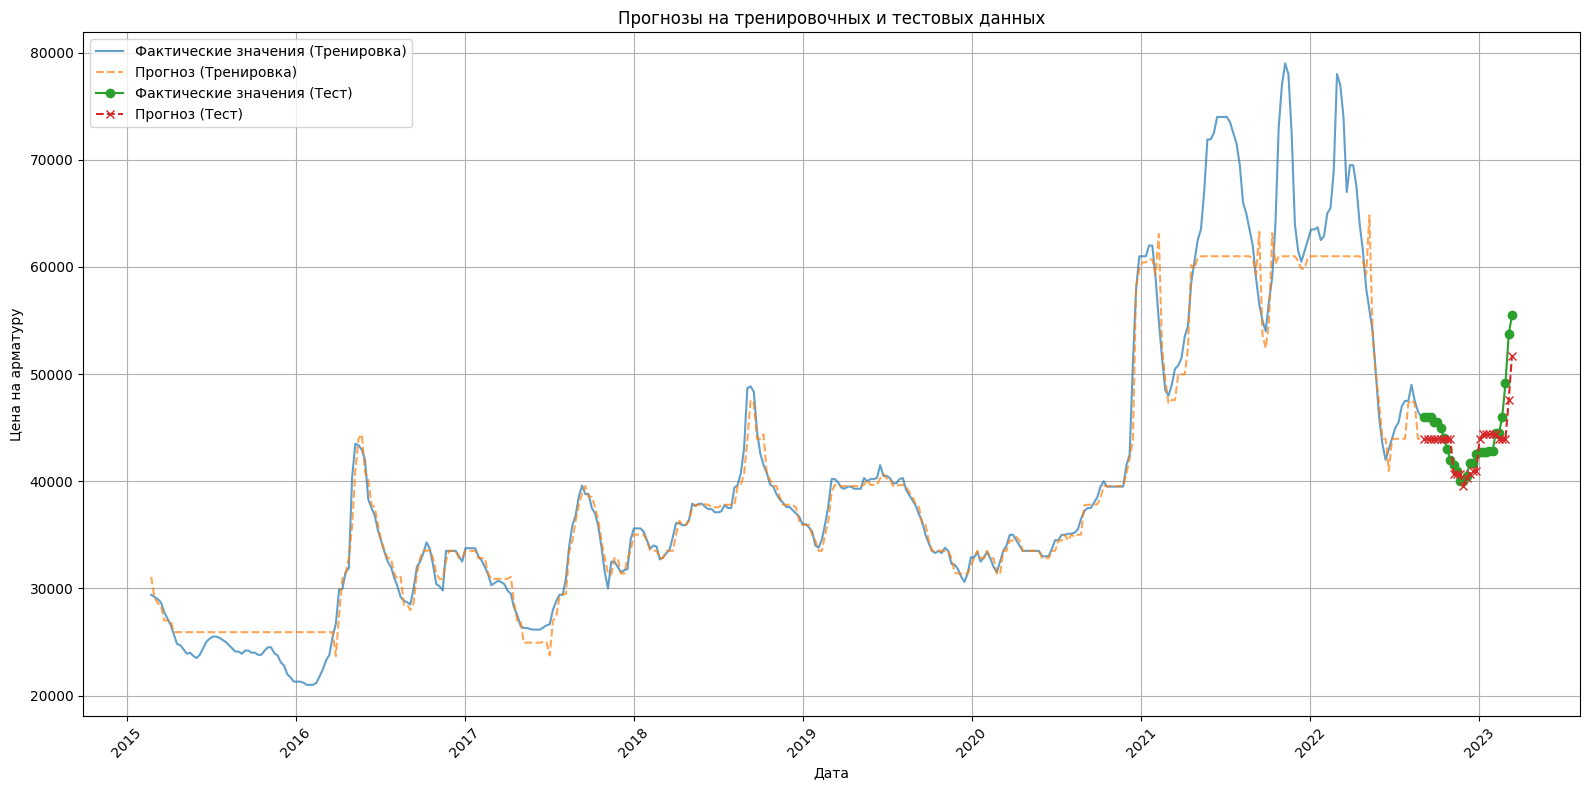


=== Метрики на тесте ===
MAE: 1593.01
RMSE: 2106.97
R²: 0.65

=== Проверка на переобучение ===
MAE на трейне: 1760.96
MAE на тесте: 1593.01
Модель не переобучена: MAE на трейне не меньше MAE на тесте.


In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
train = pd.read_excel('train.xlsx', sheet_name='Sheet1', parse_dates=['dt'])
test = pd.read_excel('test.xlsx', sheet_name='Sheet1', parse_dates=['dt'])

# Корректное объединение (без сортировки!)
full_df = pd.concat([train, test]).sort_values("dt").reset_index(drop=True)

# Создание расширенных временных признаков
def create_features(df):
    df = df.copy()
    df['year'] = df['dt'].dt.year
    df['month'] = df['dt'].dt.month
    df['week'] = df['dt'].dt.isocalendar().week
    df['day_of_week'] = df['dt'].dt.dayofweek
    df['day_of_month'] = df['dt'].dt.day
    df['is_month_start'] = df['dt'].dt.is_month_start.astype(int)
    df['quarter'] = df['dt'].dt.quarter
    df['rolling_7_mean'] = df['Цена на арматуру'].rolling(7).mean().shift(1)  # Исключаем текущее значение
    return df

full_df = create_features(full_df)

# Создание лагов с защитой от утечки
lags = [1, 2]
for lag in lags:
    full_df[f'lag_{lag}'] = full_df['Цена на арматуру'].shift(lag)

# Удаление пропусков после создания признаков
full_df = full_df.dropna().reset_index(drop=True)

# Разделение на трейн и тест по исходным границам
test_size = len(test)
train_part = full_df.iloc[:-test_size]
test_part = full_df.iloc[-test_size:]

# Подготовка данных
features = [col for col in full_df.columns if col not in ['dt', 'Цена на арматуру']]
X_train = train_part[features]
y_train = train_part['Цена на арматуру']
X_test = test_part[features]
y_test = test_part['Цена на арматуру']

# Масштабирование с учетом временного порядка
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Настройка моделей с кросс-валидацией
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=10,
    random_state=42
)

gb = GradientBoostingRegressor(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=10,
    random_state=42
)

# Стекинг-регрессор
ensemble = StackingRegressor(
    estimators=[
        ('rf', rf),
        ('gb', gb)
    ],
    final_estimator=GradientBoostingRegressor(n_estimators=50)
)

# Обучение
ensemble.fit(X_train_scaled, y_train)
preds = ensemble.predict(X_test_scaled)

# Метрики
print('=== Metrics ===')
print(f'MAE: {mean_absolute_error(y_test, preds):.2f}')
print(f'MSE: {mean_squared_error(y_test, preds):.2f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.2f}')
print(f'R²: {r2_score(y_test, preds):.2f}')

# Визуализация прогнозов
plt.figure(figsize=(16, 8))
plt.plot(test_part['dt'], y_test, label='Фактические значения', marker='o')
plt.plot(test_part['dt'], preds, label='Прогноз', linestyle='--', marker='x')
plt.title('Прогноз vs Факт (Только тестовые данные)')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
ensemble.fit(X_train_scaled, y_train)

# Предсказания на тренировочных и тестовых данных
train_preds = ensemble.predict(X_train_scaled)
test_preds = ensemble.predict(X_test_scaled)

# Метрики для трейна и теста
def print_metrics(y_true, preds, label):
    print(f'\n{label}:')
    print(f'MAE: {mean_absolute_error(y_true, preds):.2f}')
    print(f'MSE: {mean_squared_error(y_true, preds):.2f}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_true, preds)):.2f}')
    print(f'R²: {r2_score(y_true, preds):.2f}')

print('=== Train Metrics ===')
print_metrics(y_train, train_preds, 'Train')

print('\n=== Test Metrics ===')
print_metrics(y_test, test_preds, 'Test')

# Визуализация распределения ошибок
plt.figure(figsize=(12, 6))
plt.hist(y_train - train_preds, bins=30, alpha=0.5, label='Train Errors')
plt.hist(y_test - test_preds, bins=30, alpha=0.5, label='Test Errors')
plt.title('Распределение ошибок')
plt.legend()
plt.show()

# Кросс-валидация с временным разделением
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

for train_index, val_index in tscv.split(X_train):
    X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    ensemble.fit(X_train_cv, y_train_cv)
    val_preds = ensemble.predict(X_val_cv)
    
    cv_scores.append(r2_score(y_val_cv, val_preds))

print('\n=== Cross-Validation Scores ===')
print(f'Средний R²: {np.mean(cv_scores):.2f}')
print(f'Стандартное отклонение R²: {np.std(cv_scores):.2f}')
print(f'Все оценки: {cv_scores}')

# Визуализация прогнозов
plt.figure(figsize=(16, 8))
plt.plot(train_part['dt'], y_train, label='Фактические значения (Тренировка)', alpha=0.7)
plt.plot(train_part['dt'], train_preds, label='Прогноз (Тренировка)', linestyle='--', alpha=0.7)
plt.plot(test_part['dt'], y_test, label='Фактические значения (Тест)', marker='o')
plt.plot(test_part['dt'], test_preds, label='Прогноз (Тест)', linestyle='--', marker='x')
plt.title('Прогнозы на тренировочных и тестовых данных')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Метрики
print("\n=== Метрики на тесте ===")
print(f"MAE: {mean_absolute_error(y_test, test_preds):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, test_preds)):.2f}")
print(f"R²: {r2_score(y_test, test_preds):.2f}")

print("\n=== Проверка на переобучение ===")
mae_train = mean_absolute_error(y_train, train_preds)
mae_test = mean_absolute_error(y_test, test_preds)

print(f"MAE на трейне: {mae_train:.2f}")
print(f"MAE на тесте: {mae_test:.2f}")

# Проверка на переобучение через разницу в MAE
if mae_train < mae_test:
    print("Модель может быть переобучена: MAE на трейне меньше MAE на тесте.")
else:
    print("Модель не переобучена: MAE на трейне не меньше MAE на тесте.")


Train Metrics:
MAE: 1805.94
RMSE: 3704.72
R²: 0.92

Test Metrics:
MAE: 902.21
RMSE: 1049.33
R²: -1.33


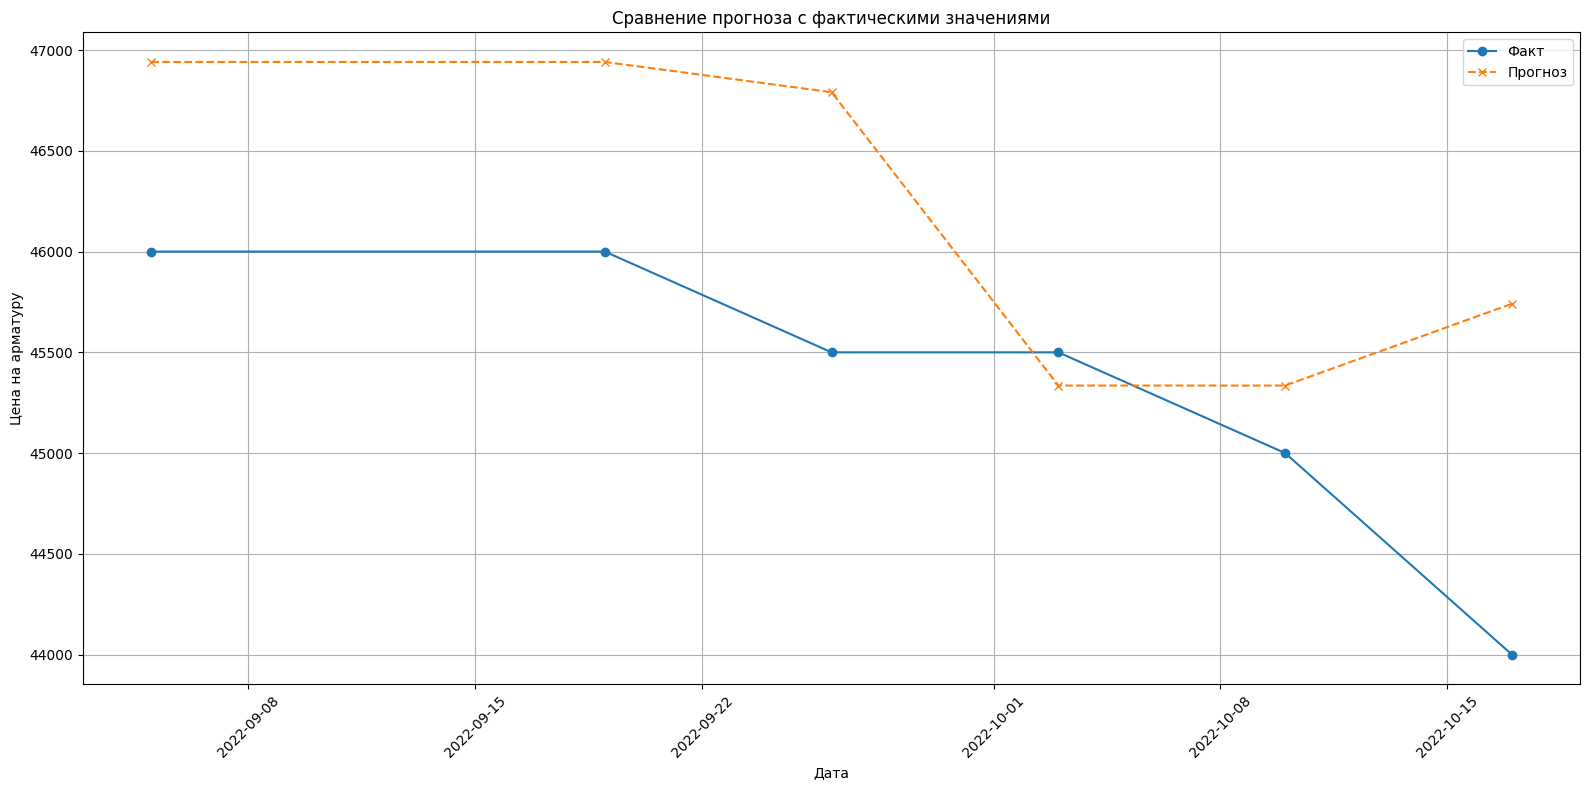

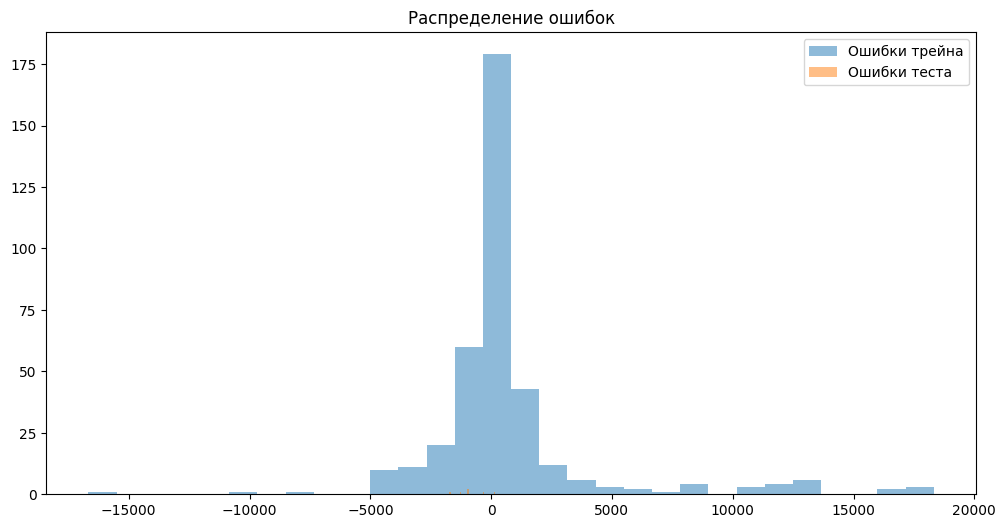


Средний R² на кросс-валидации: -0.33


In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
train = pd.read_excel('train.xlsx', sheet_name='Sheet1', parse_dates=['dt'])
test = pd.read_excel('test.xlsx', sheet_name='Sheet1', parse_dates=['dt'])

# Функция для создания базовых признаков
def create_base_features(df):
    df = df.copy()
    df['year'] = df['dt'].dt.year
    df['month'] = df['dt'].dt.month
    df['week'] = df['dt'].dt.isocalendar().week
    df['day_of_week'] = df['dt'].dt.dayofweek
    df['day_of_month'] = df['dt'].dt.day
    df['is_month_start'] = df['dt'].dt.is_month_start.astype(int)
    df['quarter'] = df['dt'].dt.quarter
    return df

# Обработка тренировочных данных
def process_train(df):
    df = create_base_features(df)
    
    # Скользящее среднее
    df['rolling_7_mean'] = df['Цена на арматуру'].rolling(7, min_periods=1).mean().shift(1)
    
    # Создание лагов
    lags = [1, 7, 14, 21, 28]
    for lag in lags:
        df[f'lag_{lag}'] = df['Цена на арматуру'].shift(lag)
    
    return df.dropna()

# Обработка тестовых данных с использованием информации из трейна
def process_test(train_df, test_df):
    test_df = create_base_features(test_df)
    full_series = pd.concat([train_df['Цена на арматуру'], test_df['Цена на арматуру']])
    
    # Скользящее среднее с учетом трейна
    test_df['rolling_7_mean'] = full_series.rolling(7, min_periods=1).mean().shift(1).iloc[len(train_df):]
    
    # Создание лагов с подтягиванием данных из трейна
    lags = [1, 7, 14, 21, 28]
    for lag in lags:
        lag_values = np.concatenate([
            train_df['Цена на арматуру'].values[-lag:],
            test_df['Цена на арматуру'].shift(lag).fillna(method='ffill').values
        ])
        test_df[f'lag_{lag}'] = lag_values[:len(test_df)]
    
    return test_df.dropna()

# Обработка данных
train_processed = process_train(train)
test_processed = process_test(train, test)

# Определение фичей
features = [col for col in train_processed.columns if col not in ['dt', 'Цена на арматуру']]

# Разделение данных
X_train = train_processed[features]
y_train = train_processed['Цена на арматуру']
X_test = test_processed[features]
y_test = test_processed['Цена на арматуру']

# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Инициализация моделей
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=10,
    random_state=42
)

gb = GradientBoostingRegressor(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=10,
    random_state=42
)

# Стекинг-модель
ensemble = StackingRegressor(
    estimators=[('rf', rf), ('gb', gb)],
    final_estimator=GradientBoostingRegressor(n_estimators=50)
)

# Обучение и предсказание
ensemble.fit(X_train_scaled, y_train)
train_preds = ensemble.predict(X_train_scaled)
test_preds = ensemble.predict(X_test_scaled)

# Метрики
def print_metrics(y_true, preds, label):
    print(f'\n{label}:')
    print(f'MAE: {mean_absolute_error(y_true, preds):.2f}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_true, preds)):.2f}')
    print(f'R²: {r2_score(y_true, preds):.2f}')

print_metrics(y_train, train_preds, 'Train Metrics')
print_metrics(y_test, test_preds, 'Test Metrics')

# Визуализация
plt.figure(figsize=(16,8))
plt.plot(test_processed['dt'], y_test, label='Факт', marker='o')
plt.plot(test_processed['dt'], test_preds, label='Прогноз', linestyle='--', marker='x')
plt.title('Сравнение прогноза с фактическими значениями')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Анализ переобучения
plt.figure(figsize=(12,6))
plt.hist(y_train - train_preds, bins=30, alpha=0.5, label='Ошибки трейна')
plt.hist(y_test - test_preds, bins=30, alpha=0.5, label='Ошибки теста')
plt.title('Распределение ошибок')
plt.legend()
plt.show()

# Кросс-валидация
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

for train_idx, val_idx in tscv.split(X_train):
    X_train_cv, X_val_cv = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    ensemble.fit(X_train_cv, y_train_cv)
    cv_scores.append(r2_score(y_val_cv, ensemble.predict(X_val_cv)))

print(f'\nСредний R² на кросс-валидации: {np.mean(cv_scores):.2f}')


Test Metrics:
MAE: 1641.21
RMSE: 2031.23
R²: 0.68

Baseline (Last Value):
MAE: 767.86
RMSE: 1285.22
R²: 0.87

Первые 5 строк тестовых данных:
          dt  Цена на арматуру    lag_1
0 2022-09-05             46000  46000.0
1 2022-09-12             46000  46000.0
2 2022-09-19             46000  46000.0
3 2022-09-26             45500  46000.0
4 2022-10-03             45500  45500.0


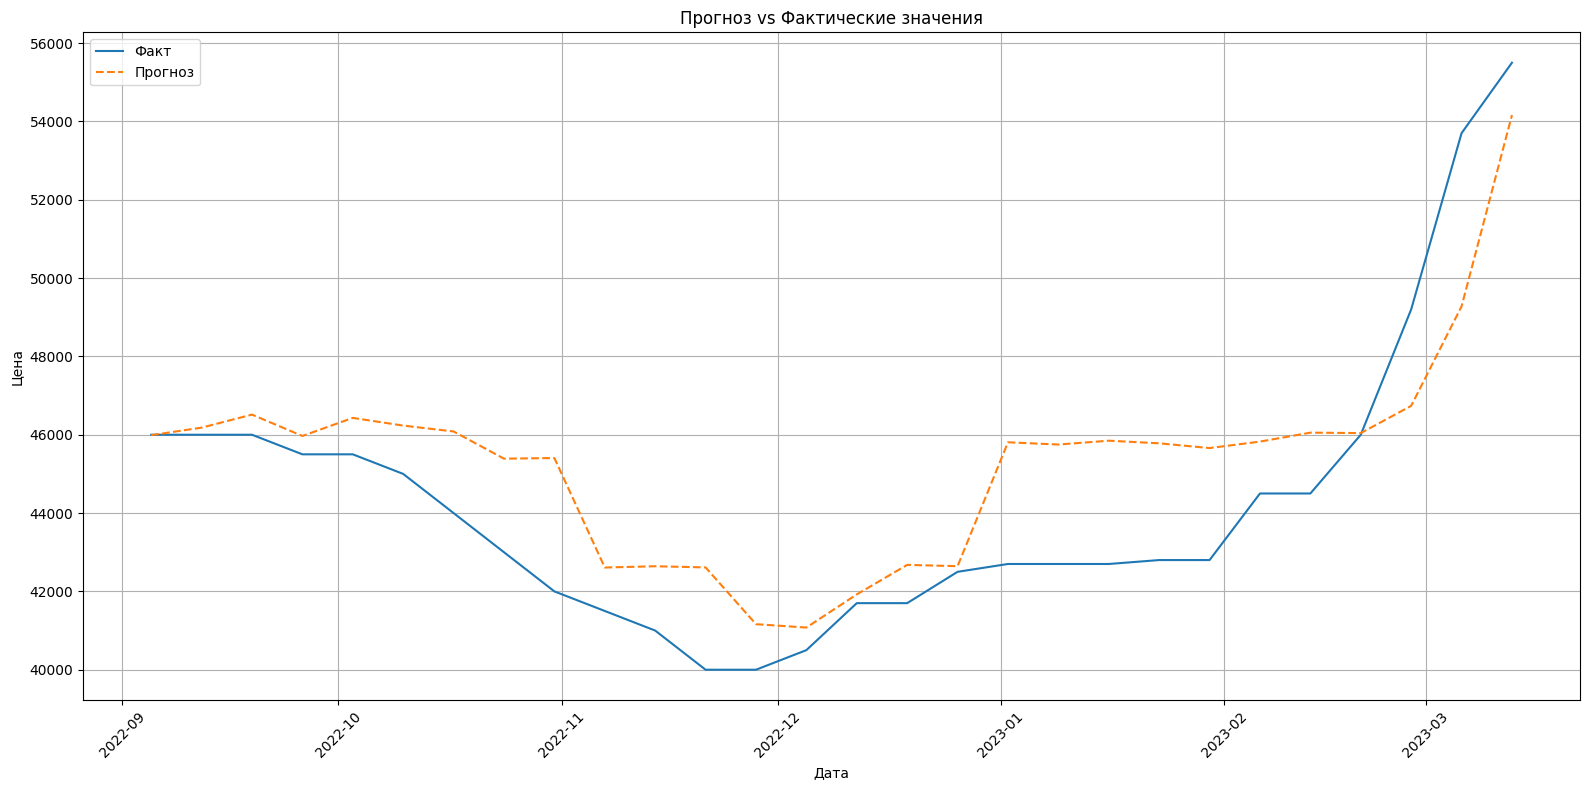

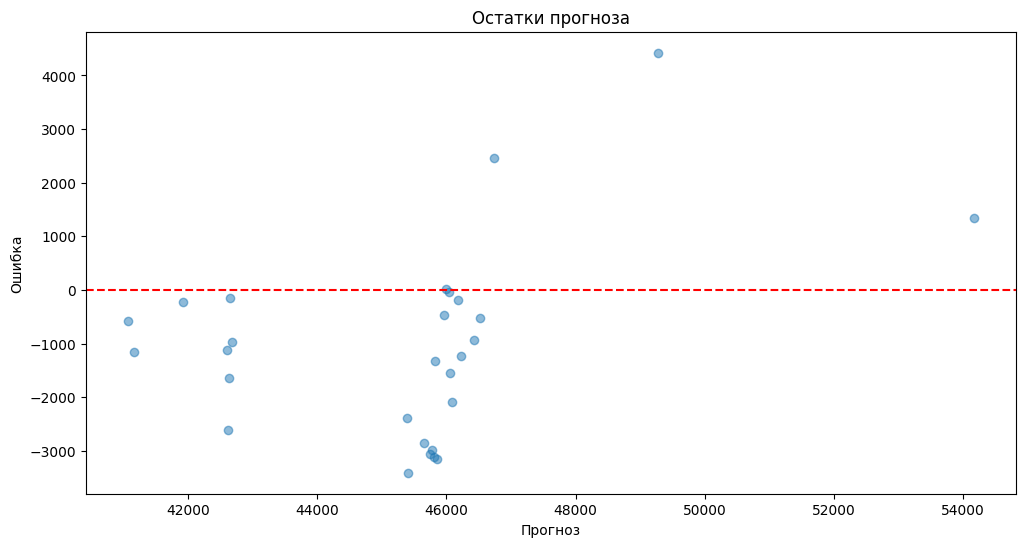

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
train = pd.read_excel('train.xlsx', sheet_name='Sheet1', parse_dates=['dt'])
test = pd.read_excel('test.xlsx', sheet_name='Sheet1', parse_dates=['dt'])

# Функция для создания признаков с защитой от утечек
def create_features(df, train_series=None):
    df = df.copy()
    
    # Базовые временные признаки
    df['year'] = df['dt'].dt.year
    df['month'] = df['dt'].dt.month
    df['day_of_week'] = df['dt'].dt.dayofweek
    df['day_of_month'] = df['dt'].dt.day
    
    # Создание лагов только из тренировочных данных
    if train_series is not None:
        full_series = pd.concat([train_series, df['Цена на арматуру']])
    else:
        full_series = df['Цена на арматуру']
    
    # Лаги
    lags = [1, 7, 14, 21, 28]
    for lag in lags:
        if train_series is not None:
            df[f'lag_{lag}'] = full_series.shift(lag).iloc[-len(df):].values
        else:
            df[f'lag_{lag}'] = df['Цена на арматуру'].shift(lag)
    
    # Скользящее среднее только по историческим данным
    if train_series is not None:
        rolling_mean = full_series.rolling(7).mean().shift(1)
        df['rolling_7_mean'] = rolling_mean.iloc[-len(df):].values
    else:
        df['rolling_7_mean'] = df['Цена на арматуру'].rolling(7).mean().shift(1)
    
    return df.dropna()

# Обработка данных
train_processed = create_features(train)
test_processed = create_features(test, train_series=train['Цена на арматуру'])

# Выравнивание признаков
common_features = list(set(train_processed.columns) & set(test_processed.columns))
features = [col for col in common_features if col not in ['dt', 'Цена на арматуру']]

# Разделение данных
X_train = train_processed[features]
y_train = train_processed['Цена на арматуру']
X_test = test_processed[features]
y_test = test_processed['Цена на арматуру']

# Масштабирование только на трейне
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Упрощенная модель
base_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Обучение и предсказание
base_model.fit(X_train_scaled, y_train)
test_preds = base_model.predict(X_test_scaled)

# Метрики
def print_metrics(y_true, preds, label):
    print(f'\n{label}:')
    print(f'MAE: {mean_absolute_error(y_true, preds):.2f}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_true, preds)):.2f}')  # Исправлено
    print(f'R²: {r2_score(y_true, preds):.2f}')

# Вызов функции с конкретными данными
print_metrics(y_test, test_preds, 'Test Metrics')

# Проверка базового бенчмарка
if 'lag_1' in test_processed.columns:
    benchmark_preds = test_processed['lag_1'].values
    print_metrics(y_test, benchmark_preds, 'Baseline (Last Value)')
else:
    print("\nОшибка: lag_1 отсутствует в тестовых данных")

# Проверка наличия данных
print("\nПервые 5 строк тестовых данных:")
print(test_processed[['dt', 'Цена на арматуру', 'lag_1']].head())

# Визуализация
plt.figure(figsize=(16,8))
plt.plot(test_processed['dt'], y_test, label='Факт')
plt.plot(test_processed['dt'], test_preds, label='Прогноз', linestyle='--')
plt.title('Прогноз vs Фактические значения')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Анализ остатков
residuals = y_test - test_preds
plt.figure(figsize=(12,6))
plt.scatter(test_preds, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Остатки прогноза')
plt.xlabel('Прогноз')
plt.ylabel('Ошибка')
plt.show()

=== Metrics ===
MAE: 2104.68
MSE: 7114999.76
RMSE: 2667.40
R²: 0.44


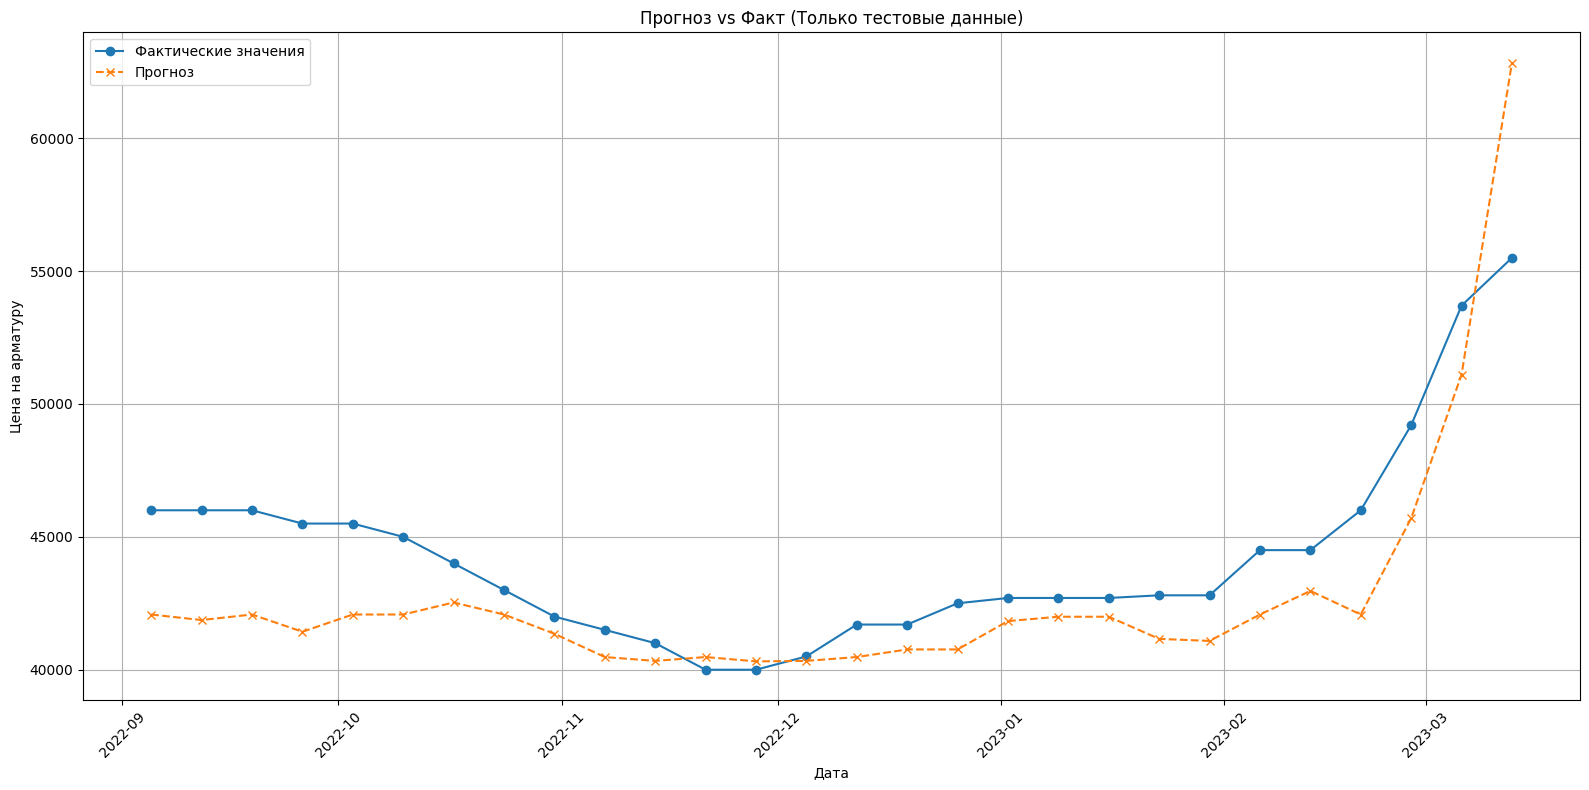

=== Train Metrics ===

Train:
MAE: 2506.36
MSE: 23479784.74
RMSE: 4845.59
R²: 0.87

=== Test Metrics ===

Test:
MAE: 2104.68
MSE: 7114999.76
RMSE: 2667.40
R²: 0.44


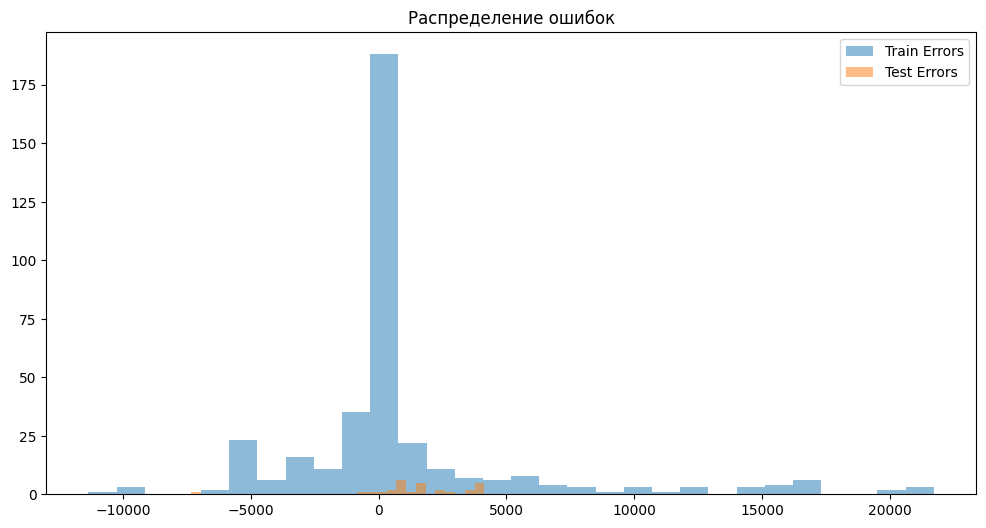


=== Cross-Validation Scores ===
Средний R²: -0.66
Стандартное отклонение R²: 1.09
Все оценки: [-1.9153611319082842, -0.21116800472827957, 0.832238652701227, -0.08721526534405899, -1.9417910436644283]


ValueError: x and y must have same first dimension, but have shapes (393,) and (372,)

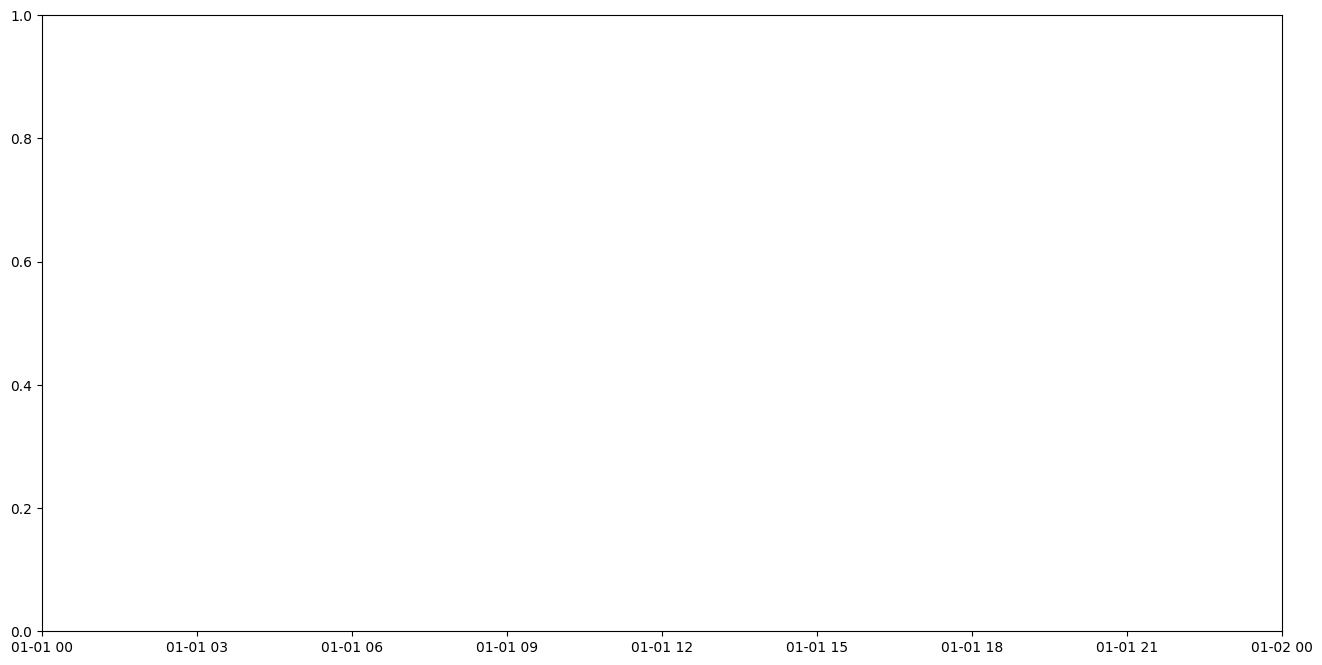

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.ensemble import StackingRegressor
# from xgboost import XGBRegressor
# from catboost import CatBoostRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import TimeSeriesSplit
# import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')

# # ... [остальная часть импортов и загрузки данных без изменений] ...

# # Настройка моделей
# xgb = XGBRegressor(
#     n_estimators=500,
#     learning_rate=0.05,
#     max_depth=8,
#     subsample=0.8,
#     colsample_bytree=0.9,
#     objective='reg:squarederror',
#     random_state=42
# )

# cat = CatBoostRegressor(
#     iterations=600,
#     learning_rate=0.05,
#     depth=8,
#     l2_leaf_reg=3,
#     random_seed=42,
#     verbose=0  # Отключаем вывод логов
# )

# # Стекинг-регрессор
# ensemble = StackingRegressor(
#     estimators=[
#         ('xgb', xgb),
#         ('cat', cat)
#     ],
#     final_estimator=CatBoostRegressor(
#         iterations=100,
#         learning_rate=0.1,
#         depth=6,
#         verbose=0,
#         random_seed=42
#     )
# )

# # Обучение
# ensemble.fit(X_train_scaled, y_train)
# preds = ensemble.predict(X_test_scaled)

# # Метрики
# print('=== Metrics ===')
# print(f'MAE: {mean_absolute_error(y_test, preds):.2f}')
# print(f'MSE: {mean_squared_error(y_test, preds):.2f}')
# print(f'RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.2f}')
# print(f'R²: {r2_score(y_test, preds):.2f}')

# # Визуализация прогнозов
# plt.figure(figsize=(16, 8))
# plt.plot(test_part['dt'], y_test, label='Фактические значения', marker='o')
# plt.plot(test_part['dt'], preds, label='Прогноз', linestyle='--', marker='x')
# plt.title('Прогноз vs Факт (Только тестовые данные)')
# plt.xlabel('Дата')
# plt.ylabel('Цена на арматуру')
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()
# ensemble.fit(X_train_scaled, y_train)

# # Предсказания на тренировочных и тестовых данных
# train_preds = ensemble.predict(X_train_scaled)
# test_preds = ensemble.predict(X_test_scaled)

# # Метрики для трейна и теста
# def print_metrics(y_true, preds, label):
#     print(f'\n{label}:')
#     print(f'MAE: {mean_absolute_error(y_true, preds):.2f}')
#     print(f'MSE: {mean_squared_error(y_true, preds):.2f}')
#     print(f'RMSE: {np.sqrt(mean_squared_error(y_true, preds)):.2f}')
#     print(f'R²: {r2_score(y_true, preds):.2f}')

# print('=== Train Metrics ===')
# print_metrics(y_train, train_preds, 'Train')

# print('\n=== Test Metrics ===')
# print_metrics(y_test, test_preds, 'Test')

# # Визуализация распределения ошибок
# plt.figure(figsize=(12, 6))
# plt.hist(y_train - train_preds, bins=30, alpha=0.5, label='Train Errors')
# plt.hist(y_test - test_preds, bins=30, alpha=0.5, label='Test Errors')
# plt.title('Распределение ошибок')
# plt.legend()
# plt.show()

# # Кросс-валидация с временным разделением
# tscv = TimeSeriesSplit(n_splits=5)
# cv_scores = []

# for train_index, val_index in tscv.split(X_train):
#     X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
#     y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
#     ensemble.fit(X_train_cv, y_train_cv)
#     val_preds = ensemble.predict(X_val_cv)
    
#     cv_scores.append(r2_score(y_val_cv, val_preds))

# print('\n=== Cross-Validation Scores ===')
# print(f'Средний R²: {np.mean(cv_scores):.2f}')
# print(f'Стандартное отклонение R²: {np.std(cv_scores):.2f}')
# print(f'Все оценки: {cv_scores}')

# # Визуализация прогнозов
# plt.figure(figsize=(16, 8))
# plt.plot(train_part['dt'], y_train, label='Фактические значения (Тренировка)', alpha=0.7)
# plt.plot(train_part['dt'], train_preds, label='Прогноз (Тренировка)', linestyle='--', alpha=0.7)
# plt.plot(test_part['dt'], y_test, label='Фактические значения (Тест)', marker='o')
# plt.plot(test_part['dt'], test_preds, label='Прогноз (Тест)', linestyle='--', marker='x')
# plt.title('Прогнозы на тренировочных и тестовых данных')
# plt.xlabel('Дата')
# plt.ylabel('Цена на арматуру')
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # Метрики
# print("\n=== Метрики на тесте ===")
# print(f"MAE: {mean_absolute_error(y_test, test_preds):.2f}")
# print(f"RMSE: {np.sqrt(mean_squared_error(y_test, test_preds)):.2f}")
# print(f"R²: {r2_score(y_test, test_preds):.2f}")

# print("\n=== Проверка на переобучение ===")
# mae_train = mean_absolute_error(y_train, train_preds)
# mae_test = mean_absolute_error(y_test, test_preds)

# print(f"MAE на трейне: {mae_train:.2f}")
# print(f"MAE на тесте: {mae_test:.2f}")

# # Проверка на переобучение через разницу в MAE
# if mae_train < mae_test:
#     print("Модель может быть переобучена: MAE на трейне меньше MAE на тесте.")
# else:
#     print("Модель не переобучена: MAE на трейне не меньше MAE на тесте.")

=== Train Metrics ===

Train:
MAE: 2013.51
MSE: 17646271.10
RMSE: 4200.75
R²: 0.90

=== Test Metrics ===

Test:
MAE: 2371.88
MSE: 6912590.02
RMSE: 2629.18
R²: 0.46


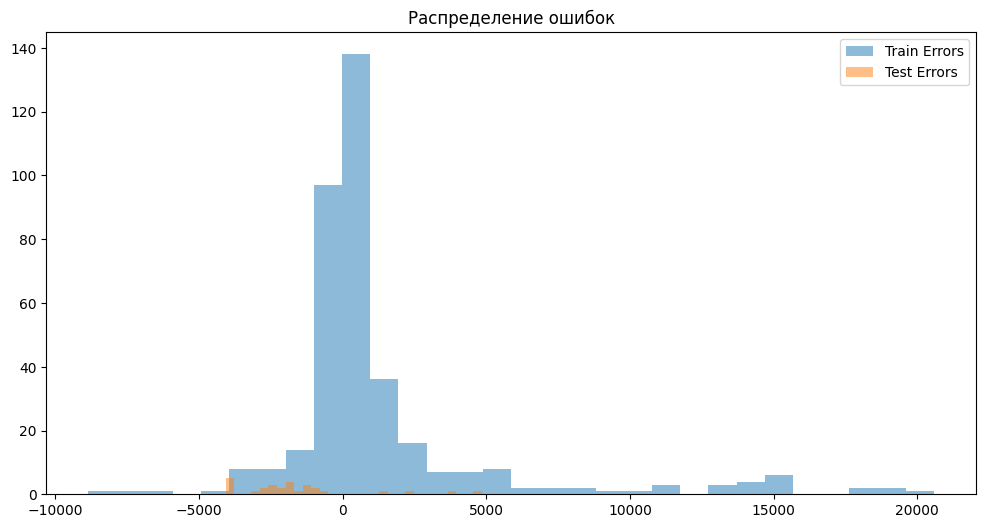


=== Cross-Validation Scores ===
Средний R²: -0.39
Стандартное отклонение R²: 0.96
Все оценки: [-1.2991454893023526, 0.2130348949314701, 0.8761741846502911, -0.04238435606144608, -1.7012932061379589]


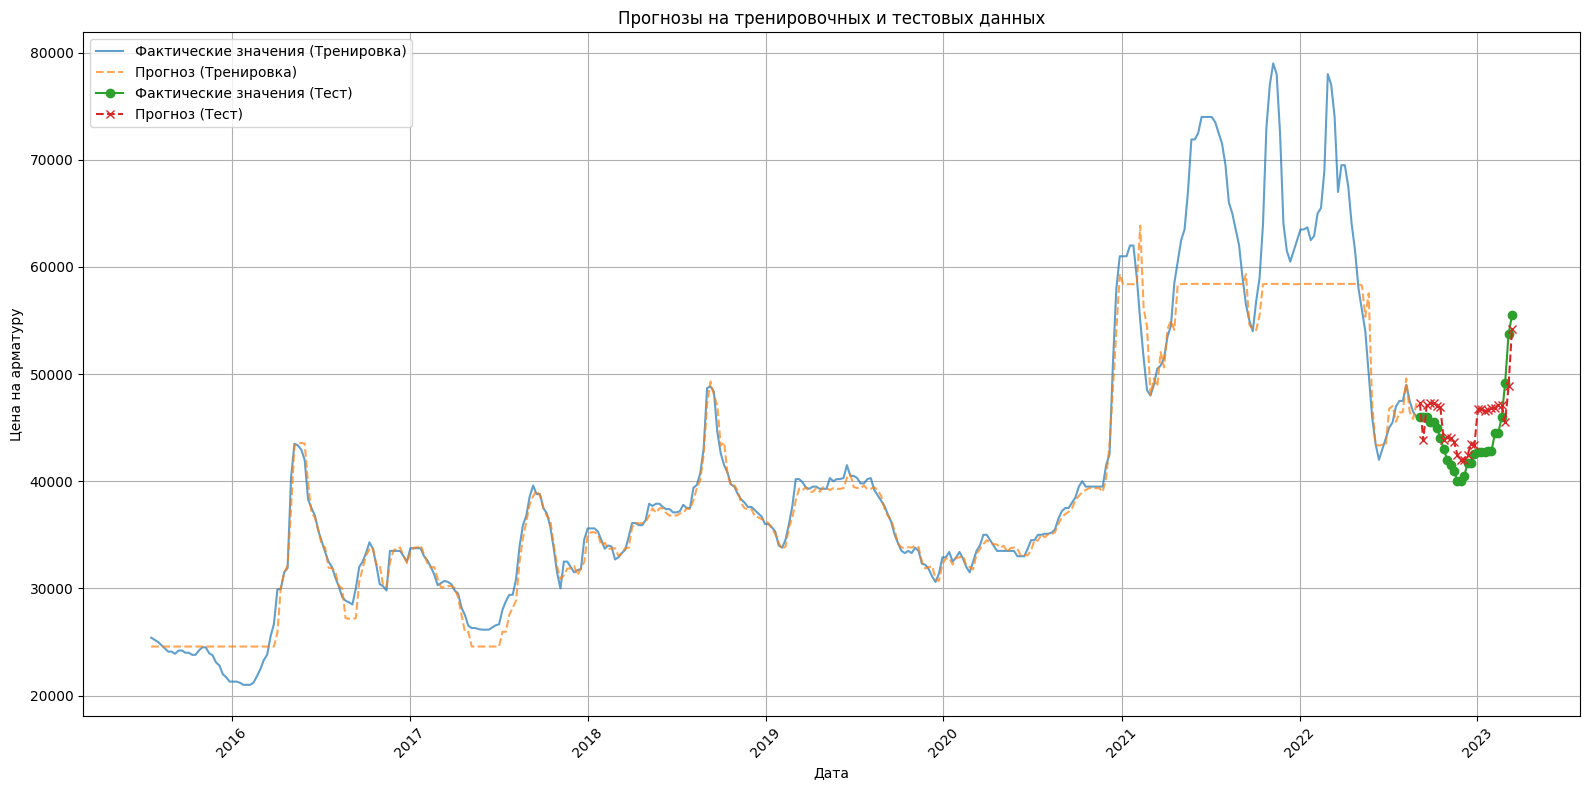


=== Проверка на переобучение ===
MAE на трейне: 2013.51
MAE на тесте: 2371.88
Модель может быть переобучена: MAE на трейне меньше MAE на тесте.


In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
train = pd.read_excel('train.xlsx', sheet_name='Sheet1', parse_dates=['dt'])
test = pd.read_excel('test.xlsx', sheet_name='Sheet1', parse_dates=['dt'])

# Функция для создания признаков с защитой от утечек
def create_features(df, train_series=None):
    df = df.copy()
    
    # Базовые временные признаки
    df['year'] = df['dt'].dt.year
    df['month'] = df['dt'].dt.month
    df['day_of_week'] = df['dt'].dt.dayofweek
    df['day_of_month'] = df['dt'].dt.day
    
    # Создание лагов только из тренировочных данных
    if train_series is not None:
        full_series = pd.concat([train_series, df['Цена на арматуру']])
    else:
        full_series = df['Цена на арматуру']
    
    # Лаги
    lags = [1, 7, 14, 21, 28]
    for lag in lags:
        if train_series is not None:
            df[f'lag_{lag}'] = full_series.shift(lag).iloc[-len(df):].values
        else:
            df[f'lag_{lag}'] = df['Цена на арматуру'].shift(lag)
    
    return df  # Возвращаем обработанный DataFrame

# Создание признаков
train = create_features(train)
train.dropna(inplace=True)  # Удаление строк с пропущенными значениями

# Для теста используем трейновые данные для создания лагов без утечек
test = create_features(test, train_series=train['Цена на арматуру'])
test.dropna(inplace=True)

# Выделение признаков и целевой переменной
X_train = train.drop(['dt', 'Цена на арматуру'], axis=1)
y_train = train['Цена на арматуру']
X_test = test.drop(['dt', 'Цена на арматуру'], axis=1)
y_test = test['Цена на арматуру']

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Настройка моделей
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=10,
    random_state=42
)

cat = CatBoostRegressor(
    iterations=600,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=0
)

# Стекинг-регрессор
ensemble = StackingRegressor(
    estimators=[
        ('rf', rf),
        ('cat', cat)
    ],
    final_estimator=CatBoostRegressor(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        verbose=0,
        random_seed=42
    )
)

# Обучение модели
ensemble.fit(X_train_scaled, y_train)

# Предсказания
train_preds = ensemble.predict(X_train_scaled)
test_preds = ensemble.predict(X_test_scaled)

# Метрики
def print_metrics(y_true, preds, label):
    print(f'\n{label}:')
    print(f'MAE: {mean_absolute_error(y_true, preds):.2f}')
    print(f'MSE: {mean_squared_error(y_true, preds):.2f}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_true, preds)):.2f}')
    print(f'R²: {r2_score(y_true, preds):.2f}')

print('=== Train Metrics ===')
print_metrics(y_train, train_preds, 'Train')

print('\n=== Test Metrics ===')
print_metrics(y_test, test_preds, 'Test')

# Визуализация ошибок
plt.figure(figsize=(12, 6))
plt.hist(y_train - train_preds, bins=30, alpha=0.5, label='Train Errors')
plt.hist(y_test - test_preds, bins=30, alpha=0.5, label='Test Errors')
plt.title('Распределение ошибок')
plt.legend()
plt.show()

# Кросс-валидация
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

for train_index, val_index in tscv.split(X_train):
    X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    ensemble.fit(X_train_cv, y_train_cv)
    val_preds = ensemble.predict(X_val_cv)
    cv_scores.append(r2_score(y_val_cv, val_preds))

print('\n=== Cross-Validation Scores ===')
print(f'Средний R²: {np.mean(cv_scores):.2f}')
print(f'Стандартное отклонение R²: {np.std(cv_scores):.2f}')
print(f'Все оценки: {cv_scores}')

# Визуализация прогнозов
plt.figure(figsize=(16, 8))
plt.plot(train['dt'], y_train, label='Фактические значения (Тренировка)', alpha=0.7)
plt.plot(train['dt'], train_preds, label='Прогноз (Тренировка)', linestyle='--', alpha=0.7)
plt.plot(test['dt'], y_test, label='Фактические значения (Тест)', marker='o')
plt.plot(test['dt'], test_preds, label='Прогноз (Тест)', linestyle='--', marker='x')
plt.title('Прогнозы на тренировочных и тестовых данных')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Проверка на переобучение
print("\n=== Проверка на переобучение ===")
mae_train = mean_absolute_error(y_train, train_preds)
mae_test = mean_absolute_error(y_test, test_preds)
print(f"MAE на трейне: {mae_train:.2f}")
print(f"MAE на тесте: {mae_test:.2f}")

if mae_train < mae_test:
    print("Модель может быть переобучена: MAE на трейне меньше MAE на тесте.")
else:
    print("Модель не переобучена: MAE на трейне не меньше MAE на тесте.")

Лучшие параметры для RandomForest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}

=== Оценка RandomForest ===
MAE: 982.99
RMSE: 1599.32
R²: 0.98

=== Оценка CatBoost ===
MAE: 995.68
RMSE: 1593.47
R²: 0.98

=== Оценка Ансамбль ===
MAE: 945.11
RMSE: 1553.74
R²: 0.98

=== Оценка RandomForest (Test) ===
MAE: 1713.35
RMSE: 2061.40
R²: 0.77

=== Оценка CatBoost (Test) ===
MAE: 2126.36
RMSE: 3133.56
R²: 0.47

=== Оценка Ансамбль (Test) ===
MAE: 1883.75
RMSE: 2491.00
R²: 0.66


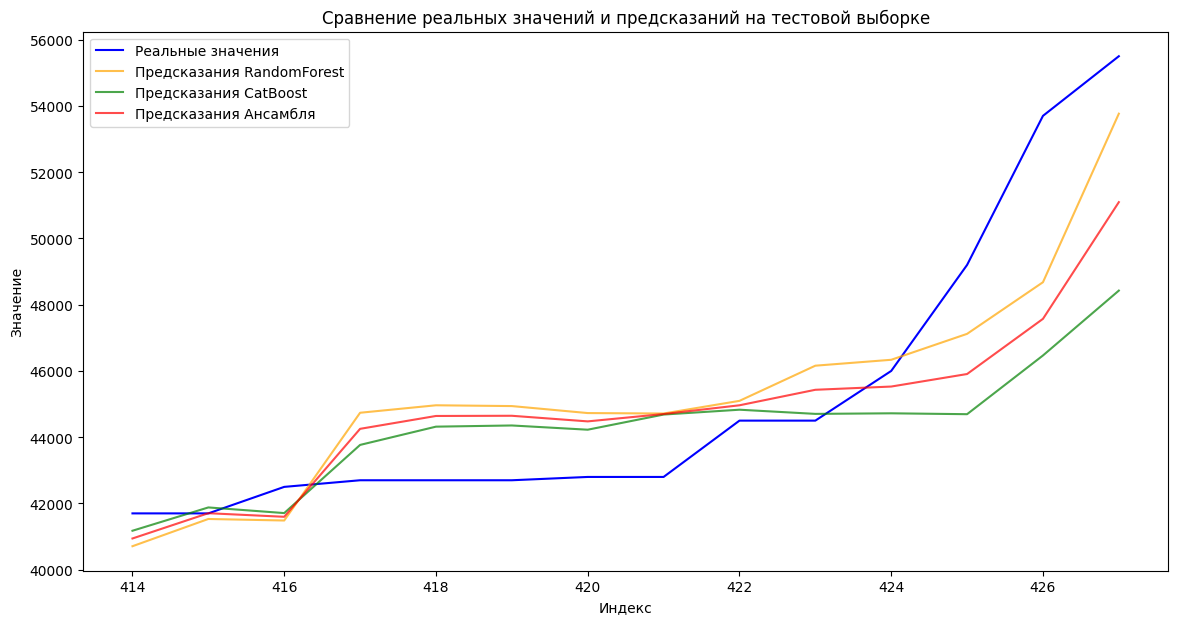

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Загрузка данных
train = pd.read_excel('train.xlsx', parse_dates=['dt'])
test = pd.read_excel('test.xlsx', parse_dates=['dt'])

# 2. Объединение данных
combined = pd.concat([train, test]).sort_values('dt').reset_index(drop=True)

# 3. Предобработка данных
def create_features(df):
    df = df.copy()
    df['month'] = df['dt'].dt.month
    df['year'] = df['dt'].dt.year
    df['day_of_week'] = df['dt'].dt.dayofweek + 1
    df['quarter'] = df['dt'].dt.quarter
    
    # Лаги
    for lag in [1, 3, 7, 14]:
        df[f'lag_{lag}'] = df['Цена на арматуру'].shift(lag)
    
    # Скользящие характеристики
    df['rolling_mean_7'] = df['Цена на арматуру'].rolling(7).mean().shift(1)
    df['rolling_std_7'] = df['Цена на арматуру'].rolling(7).std().shift(1)

    # Удаление пропусков
    df.dropna(inplace=True)
    return df

# Создание признаков
processed = create_features(combined)

# 4. Разделение данных на обучающую, валидационную и тестовую выборки
train_size = len(train)
train_val_df = processed.iloc[:train_size]
test_df = processed.iloc[train_size:]

X = train_val_df[features]
y = train_val_df[target]

# Делим данные на обучающую и валидационную выборки (80% - train, 20% - validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Поиск лучших гиперпараметров для RandomForestRegressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                               scoring='neg_mean_absolute_error', cv=5)
grid_search_rf.fit(X_train, y_train)

print("Лучшие параметры для RandomForest:", grid_search_rf.best_params_)
best_rf_model = grid_search_rf.best_estimator_

# 6. Обучение CatBoostRegressor
cat_model = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, random_seed=42, verbose=0)
cat_model.fit(X_train, y_train)

# 7. Предсказания на валидационной выборке
rf_val_preds = best_rf_model.predict(X_val)
cat_val_preds = cat_model.predict(X_val)

# 8. Ансамбль моделей (усреднение предсказаний на валидационной выборке)
ensemble_val_preds = (rf_val_preds + cat_val_preds) / 2

# 9. Оценка моделей на валидационной выборке
evaluate_model(y_val, rf_val_preds, "RandomForest")
evaluate_model(y_val, cat_val_preds, "CatBoost")
evaluate_model(y_val, ensemble_val_preds, "Ансамбль")

# 10. Предсказания на тестовой выборке
rf_test_preds = best_rf_model.predict(test_df[features])
cat_test_preds = cat_model.predict(test_df[features])
ensemble_test_preds = (rf_test_preds + cat_test_preds) / 2

# 11. Оценка моделей на тестовой выборке
y_test = test_df[target]
evaluate_model(y_test, rf_test_preds, "RandomForest (Test)")
evaluate_model(y_test, cat_test_preds, "CatBoost (Test)")
evaluate_model(y_test, ensemble_test_preds, "Ансамбль (Test)")

# 12. Визуализация предсказаний на тестовой выборке
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Реальные значения', color='blue')
plt.plot(y_test.index, rf_test_preds, label='Предсказания RandomForest', color='orange', alpha=0.7)
plt.plot(y_test.index, cat_test_preds, label='Предсказания CatBoost', color='green', alpha=0.7)
plt.plot(y_test.index, ensemble_test_preds, label='Предсказания Ансамбля', color='red', alpha=0.7)
plt.title('Сравнение реальных значений и предсказаний на тестовой выборке')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()
plt.show()


=== Metrics ===
MAE: 1569.60
MSE: 4566845.50
RMSE: 2137.02
R²: 0.64


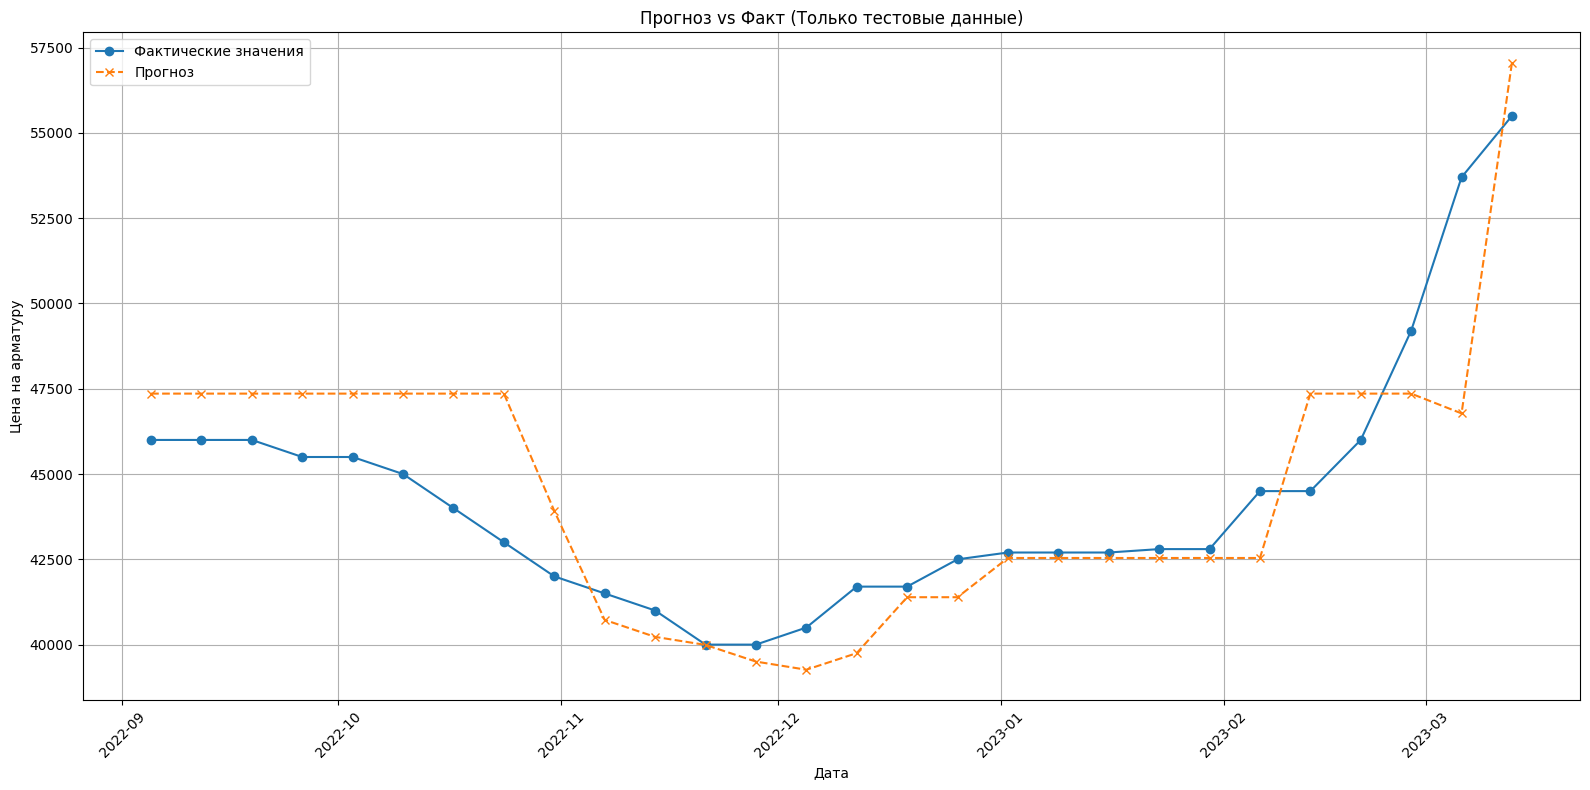

=== Train Metrics ===

Train:
MAE: 1745.85
MSE: 11922377.00
RMSE: 3452.88
R²: 0.93

=== Test Metrics ===

Test:
MAE: 1569.60
MSE: 4566845.50
RMSE: 2137.02
R²: 0.64


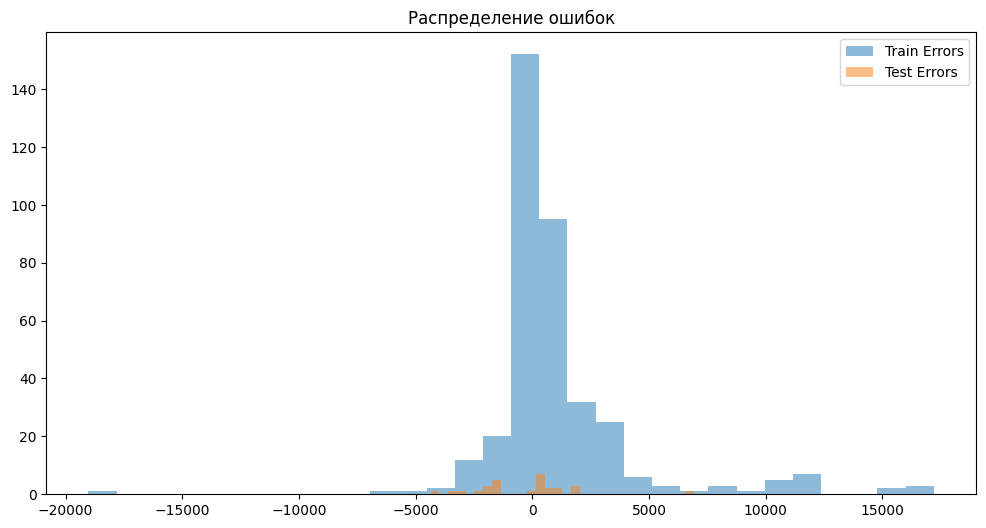


=== Cross-Validation Scores ===
Средний R²: -0.13
Стандартное отклонение R²: 0.74
Все оценки: [-0.07191097736358643, 0.5716865062713623, 0.33410024642944336, 0.05548834800720215, -1.5334267616271973]


ValueError: x and y must have same first dimension, but have shapes (393,) and (372,)

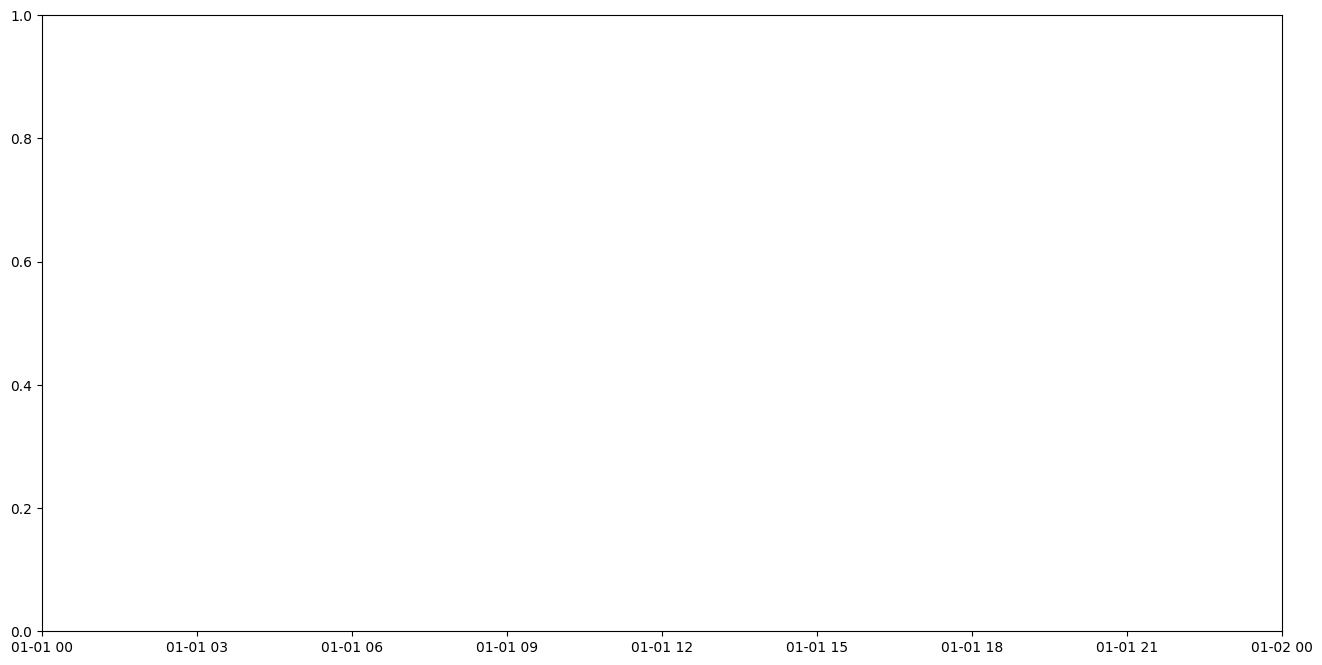

In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ... [остальная часть загрузки данных и предобработки без изменений] ...

# Настройка моделей
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=10,
    random_state=42
)

xgb = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    random_state=42
)

# Стекинг-регрессор
ensemble = StackingRegressor(
    estimators=[
        ('rf', rf),
        ('xgb', xgb)
    ],
    final_estimator=XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
)

# ... [весь остальной код остается без изменений] ...

# Обучение
ensemble.fit(X_train_scaled, y_train)
preds = ensemble.predict(X_test_scaled)

# Метрики
print('=== Metrics ===')
print(f'MAE: {mean_absolute_error(y_test, preds):.2f}')
print(f'MSE: {mean_squared_error(y_test, preds):.2f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.2f}')
print(f'R²: {r2_score(y_test, preds):.2f}')

# Визуализация прогнозов
plt.figure(figsize=(16, 8))
plt.plot(test_part['dt'], y_test, label='Фактические значения', marker='o')
plt.plot(test_part['dt'], preds, label='Прогноз', linestyle='--', marker='x')
plt.title('Прогноз vs Факт (Только тестовые данные)')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
ensemble.fit(X_train_scaled, y_train)

# Предсказания на тренировочных и тестовых данных
train_preds = ensemble.predict(X_train_scaled)
test_preds = ensemble.predict(X_test_scaled)

# Метрики для трейна и теста
def print_metrics(y_true, preds, label):
    print(f'\n{label}:')
    print(f'MAE: {mean_absolute_error(y_true, preds):.2f}')
    print(f'MSE: {mean_squared_error(y_true, preds):.2f}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_true, preds)):.2f}')
    print(f'R²: {r2_score(y_true, preds):.2f}')

print('=== Train Metrics ===')
print_metrics(y_train, train_preds, 'Train')

print('\n=== Test Metrics ===')
print_metrics(y_test, test_preds, 'Test')

# Визуализация распределения ошибок
plt.figure(figsize=(12, 6))
plt.hist(y_train - train_preds, bins=30, alpha=0.5, label='Train Errors')
plt.hist(y_test - test_preds, bins=30, alpha=0.5, label='Test Errors')
plt.title('Распределение ошибок')
plt.legend()
plt.show()

# Кросс-валидация с временным разделением
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

for train_index, val_index in tscv.split(X_train):
    X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    ensemble.fit(X_train_cv, y_train_cv)
    val_preds = ensemble.predict(X_val_cv)
    
    cv_scores.append(r2_score(y_val_cv, val_preds))

print('\n=== Cross-Validation Scores ===')
print(f'Средний R²: {np.mean(cv_scores):.2f}')
print(f'Стандартное отклонение R²: {np.std(cv_scores):.2f}')
print(f'Все оценки: {cv_scores}')

# Визуализация прогнозов
plt.figure(figsize=(16, 8))
plt.plot(train_part['dt'], y_train, label='Фактические значения (Тренировка)', alpha=0.7)
plt.plot(train_part['dt'], train_preds, label='Прогноз (Тренировка)', linestyle='--', alpha=0.7)
plt.plot(test_part['dt'], y_test, label='Фактические значения (Тест)', marker='o')
plt.plot(test_part['dt'], test_preds, label='Прогноз (Тест)', linestyle='--', marker='x')
plt.title('Прогнозы на тренировочных и тестовых данных')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Метрики
print("\n=== Метрики на тесте ===")
print(f"MAE: {mean_absolute_error(y_test, test_preds):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, test_preds)):.2f}")
print(f"R²: {r2_score(y_test, test_preds):.2f}")

print("\n=== Проверка на переобучение ===")
mae_train = mean_absolute_error(y_train, train_preds)
mae_test = mean_absolute_error(y_test, test_preds)

print(f"MAE на трейне: {mae_train:.2f}")
print(f"MAE на тесте: {mae_test:.2f}")

# Проверка на переобучение через разницу в MAE
if mae_train < mae_test:
    print("Модель может быть переобучена: MAE на трейне меньше MAE на тесте.")
else:
    print("Модель не переобучена: MAE на трейне не меньше MAE на тесте.")

Средний MAE кросс-валидации: 1531.22


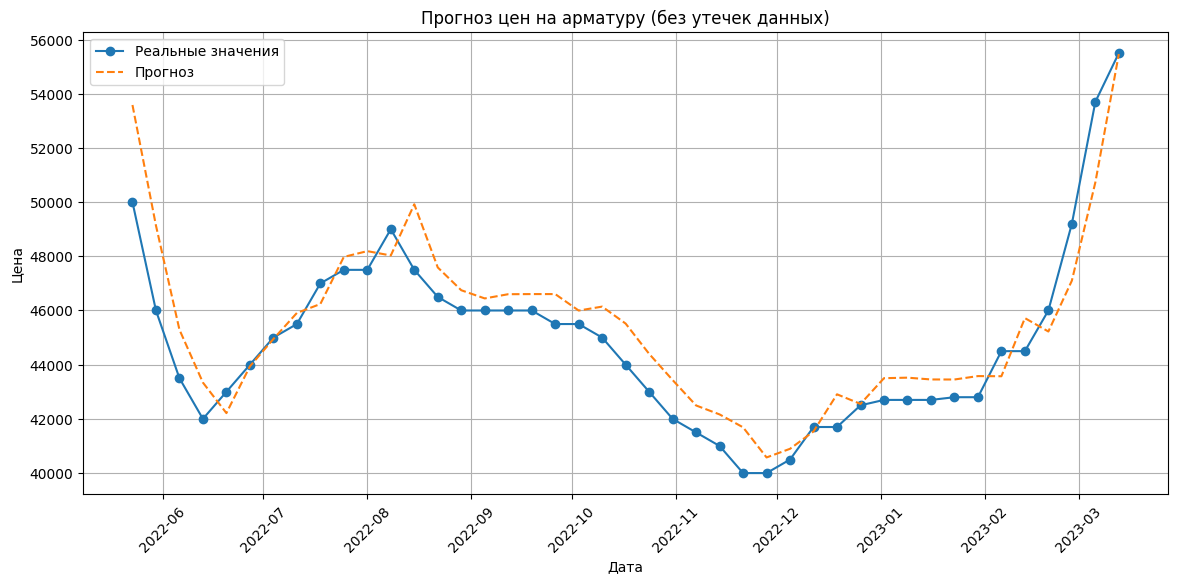


=== Метрики на тесте ===
MAE: 1049.91
RMSE: 1317.05
R²: 0.84

=== Проверка на переобучение ===
MAE на трейне: 843.70
MAE на тесте: 1049.91
Модель может быть переобучена: MAE на трейне меньше MAE на тесте.


In [ ]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Загрузка данных с правильной сортировкой по дате
train_df = pd.read_excel('train.xlsx', parse_dates=['dt']).sort_values('dt')
test_df = pd.read_excel('test.xlsx', parse_dates=['dt']).sort_values('dt')

# Объединение данных с сохранением временного порядка
full_df = pd.concat([train_df, test_df]).sort_values('dt').reset_index(drop=True)

# Функция для создания временных признаков БЕЗ УТЕЧЕК
def create_features(df):
    df = df.copy()
    
    # Временные компоненты
    df['year'] = df['dt'].dt.year
    df['month'] = df['dt'].dt.month
    df['dayofweek'] = df['dt'].dt.dayofweek
    
    # Лаги с защитой от утечек
    df['lag_1'] = df['Цена на арматуру'].shift(1)
    df['lag_2'] = df['Цена на арматуру'].shift(2)
    
    # Скользящее среднее с защитой от утечек
    df['rolling_mean_3'] = df['Цена на арматуру'].shift(1).rolling(window=3).mean()
    
    return df.dropna()

# Применение функций к данным
full_df = create_features(full_df)

# Разделение на трейн/тест БЕЗ ПЕРЕМЕШИВАНИЯ
split_idx = int(len(full_df)*0.9)
train_data = full_df.iloc[:split_idx]
test_data = full_df.iloc[split_idx:]

# Выбор фичей и таргета
features = ['year', 'month', 'dayofweek', 'lag_1', 'lag_2', 'rolling_mean_3']
target = 'Цена на арматуру'

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение модели с кросс-валидацией
tscv = TimeSeriesSplit(n_splits=3)
model = Ridge(alpha=1.0)

# Проверка на переобучение
cv_scores = -cross_val_score(model, X_train_scaled, y_train, 
                           cv=tscv, scoring='neg_mean_absolute_error')
print(f"Средний MAE кросс-валидации: {np.mean(cv_scores):.2f}")

# Финальное обучение
model.fit(X_train_scaled, y_train)

# Прогнозирование
test_preds = model.predict(X_test_scaled)
train_preds = model.predict(X_train_scaled)

# Визуализация
plt.figure(figsize=(14, 6))
plt.plot(test_data['dt'], y_test, label='Реальные значения', marker='o')
plt.plot(test_data['dt'], test_preds, label='Прогноз', linestyle='--')
plt.title('Прогноз цен на арматуру (без утечек данных)')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Метрики
print("\n=== Метрики на тесте ===")
print(f"MAE: {mean_absolute_error(y_test, test_preds):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, test_preds)):.2f}")
print(f"R²: {r2_score(y_test, test_preds):.2f}")

print("\n=== Проверка на переобучение ===")
mae_train = mean_absolute_error(y_train, train_preds)
mae_test = mean_absolute_error(y_test, test_preds)

print(f"MAE на трейне: {mae_train:.2f}")
print(f"MAE на тесте: {mae_test:.2f}")

# Проверка на переобучение через разницу в MAE
if mae_train < mae_test:
    print("Модель может быть переобучена: MAE на трейне меньше MAE на тесте.")
else:
    print("Модель не переобучена: MAE на трейне не меньше MAE на тесте.")



In [ ]:
from sklearn.model_selection import cross_val_score

# Оценка модели с использованием кросс-валидации
cv_scores = cross_val_score(ensemble, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')

# Преобразование отрицательных значений в положительные
cv_scores = -cv_scores

# Среднее значение MAE по кросс-валидации
mean_cv_mae = np.mean(cv_scores)

# Оценка на обучающей выборке
train_preds = ensemble.predict(X_train_scaled)
train_mae = mean_absolute_error(y_train, train_preds)

# Вывод результатов
print('=== Проверка на переобучение ===')
print(f'Средний MAE по кросс-валидации (обучающая выборка): {mean_cv_mae:.2f}')
print(f'MAE на обучающей выборке: {train_mae:.2f}')

# Проверка на переобучение
if train_mae < mean_cv_mae:
    print("Модель может быть переобучена.")
else:
    print("Модель не показывает признаков переобучения.")


=== Проверка на переобучение ===
Средний MAE по кросс-валидации (обучающая выборка): 5110.76
MAE на обучающей выборке: 4199.01
Модель может быть переобучена.


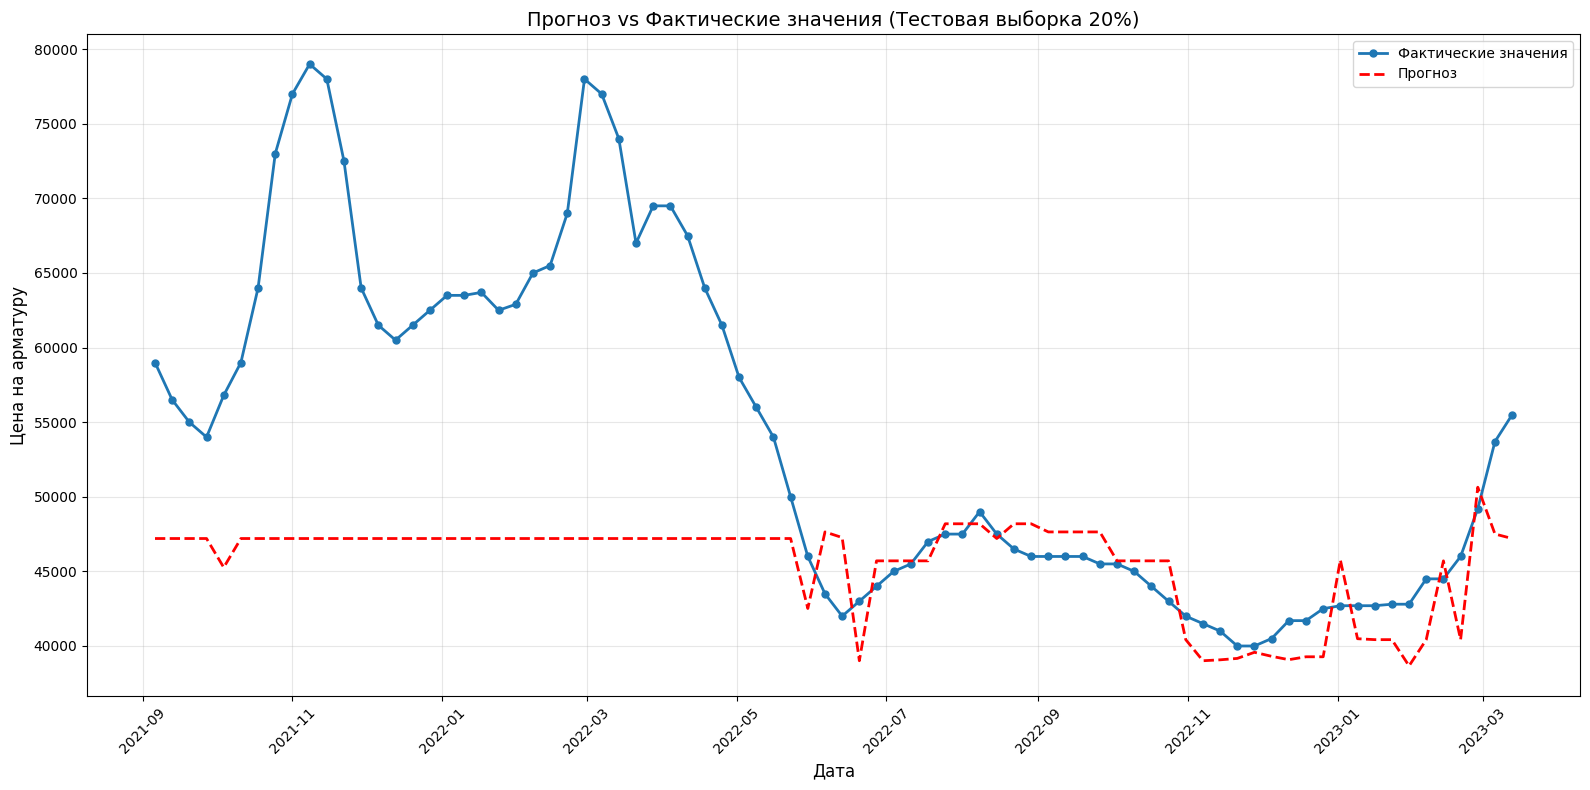

MAE: 9509.42
MSE: 174853260.08
R^2: -0.35


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Загрузка данных
train = pd.read_excel('train.xlsx', sheet_name='Sheet1', parse_dates=['dt'])
test = pd.read_excel('test.xlsx', sheet_name='Sheet1', parse_dates=['dt'])

# Объединение данных
full_df = pd.concat([train, test], axis=0).reset_index(drop=True)

# Сортировка по дате для временных рядов
full_df = full_df.sort_values('dt').reset_index(drop=True)

# Создание расширенных временных признаков
def create_features(df):
    df = df.copy()
    df['year'] = df['dt'].dt.year
    df['month'] = df['dt'].dt.month
    df['week'] = df['dt'].dt.isocalendar().week
    df['day_of_week'] = df['dt'].dt.dayofweek
    df['day_of_month'] = df['dt'].dt.day
    df['is_month_start'] = df['dt'].dt.is_month_start.astype(int)
    df['quarter'] = df['dt'].dt.quarter
    df['rolling_7_mean'] = df['Цена на арматуру'].rolling(7).mean().shift(1)
    return df

full_df = create_features(full_df)

# Создание лагов
lags = [1, 7, 14, 21, 28]
for lag in lags:
    full_df[f'lag_{lag}'] = full_df['Цена на арматуру'].shift(lag)

# Удаление пропусков
full_df = full_df.dropna().reset_index(drop=True)

# Разделение на 80% трейн / 20% тест
split_idx = int(len(full_df) * 0.8)
train_part = full_df.iloc[:split_idx]
test_part = full_df.iloc[split_idx:]

# Подготовка данных
features = [col for col in full_df.columns if col not in ['dt', 'Цена на арматуру']]
X_train = train_part[features]
y_train = train_part['Цена на арматуру']
X_test = test_part[features]
y_test = test_part['Цена на арматуру']

# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Инициализация моделей
xgb = XGBRegressor(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)

catboost = CatBoostRegressor(
    iterations=400,
    depth=8,
    learning_rate=0.05,
    verbose=0,
    random_state=42
)

rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=10,
    min_samples_split=10,
    random_state=42
)

# Стекинг-ансамбль
ensemble = StackingRegressor(
    estimators=[
        ('xgb', xgb),
        ('catboost', catboost),
        ('rf', rf)
    ],
    final_estimator=CatBoostRegressor(iterations=100, verbose=0)
)

# Обучение и предсказания
ensemble.fit(X_train_scaled, y_train)
test_preds = ensemble.predict(X_test_scaled)

# Вывод графика тестовых данных
plt.figure(figsize=(16, 8))
plt.plot(test_part['dt'], y_test, label='Фактические значения', 
         linewidth=2, marker='o', markersize=5)
plt.plot(test_part['dt'], test_preds, label='Прогноз', 
         linewidth=2, linestyle='--', color='red')
plt.title('Прогноз vs Фактические значения (Тестовая выборка 20%)', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Цена на арматуру', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Оценка модели
mae = mean_absolute_error(y_test, test_preds)
mse = mean_squared_error(y_test, test_preds)
r2 = r2_score(y_test, test_preds)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'R^2: {r2:.2f}')



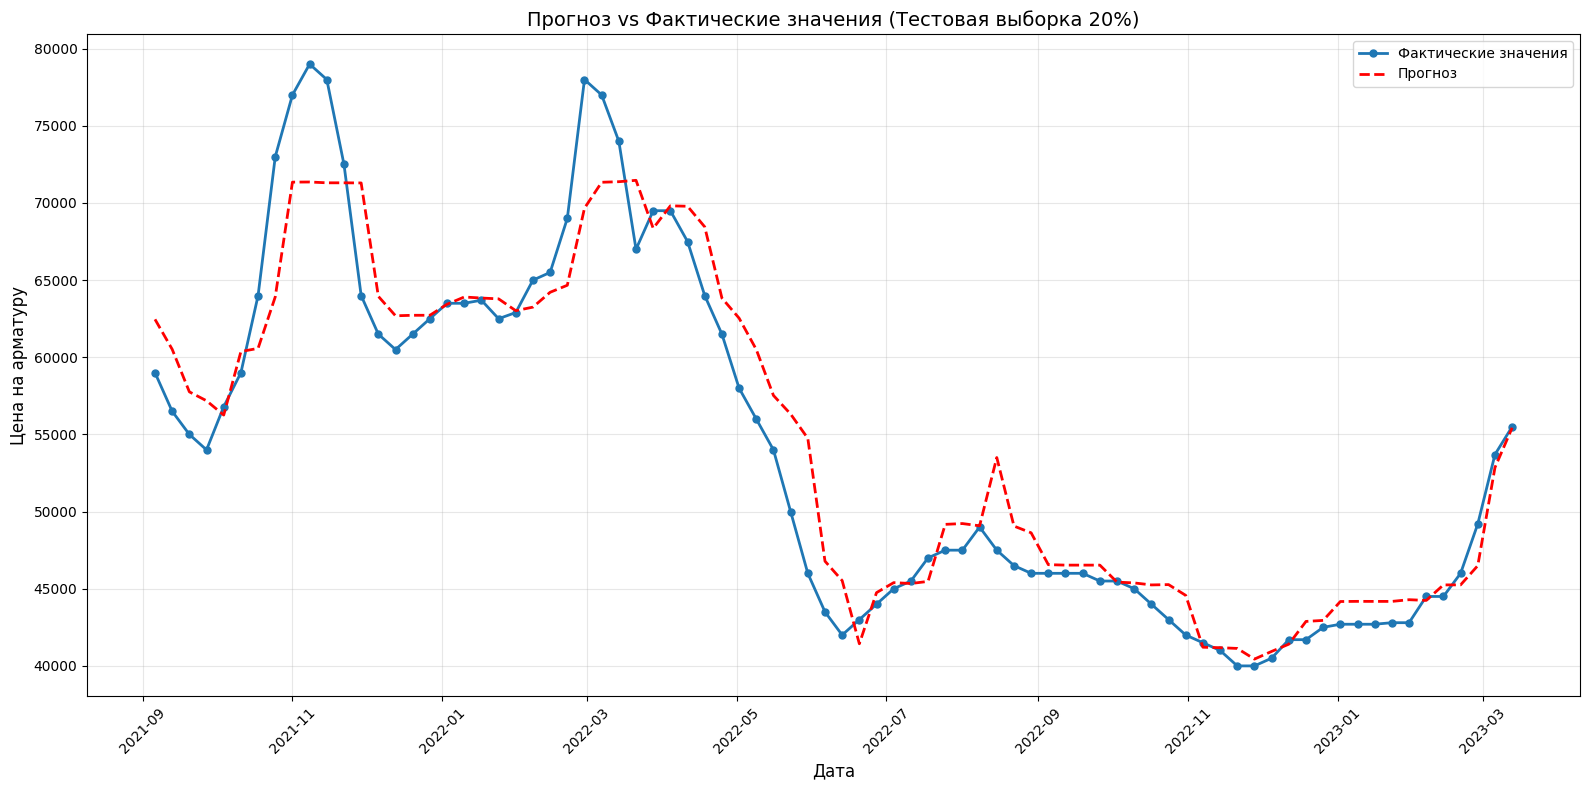

MAE: 2289.67
MSE: 10280642.44
R^2: 0.92


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Загрузка данных
train = pd.read_excel('train.xlsx', sheet_name='Sheet1', parse_dates=['dt'])
test = pd.read_excel('test.xlsx', sheet_name='Sheet1', parse_dates=['dt'])

# Объединение данных
full_df = pd.concat([train, test], axis=0).reset_index(drop=True)

# Сортировка по дате для временных рядов
full_df = full_df.sort_values('dt').reset_index(drop=True)

# Создание расширенных временных признаков
def create_features(df):
    df = df.copy()
    df['year'] = df['dt'].dt.year
    df['month'] = df['dt'].dt.month
    df['week'] = df['dt'].dt.isocalendar().week
    df['day_of_week'] = df['dt'].dt.dayofweek
    df['day_of_month'] = df['dt'].dt.day
    df['is_month_start'] = df['dt'].dt.is_month_start.astype(int)
    df['quarter'] = df['dt'].dt.quarter
    df['rolling_7_mean'] = df['Цена на арматуру'].rolling(7).mean().shift(1)
    return df

full_df = create_features(full_df)

# Создание лагов
lags = [1, 7, 14, 21, 28]
for lag in lags:
    full_df[f'lag_{lag}'] = full_df['Цена на арматуру'].shift(lag)

# Удаление пропусков
full_df = full_df.dropna().reset_index(drop=True)

# Разделение на 80% трейн / 20% тест
split_idx = int(len(full_df) * 0.8)
train_part = full_df.iloc[:split_idx]
test_part = full_df.iloc[split_idx:]

# Подготовка данных
features = [col for col in full_df.columns if col not in ['dt', 'Цена на арматуру']]
X_train = train_part[features]
y_train = train_part['Цена на арматуру']
X_test = test_part[features]
y_test = test_part['Цена на арматуру']

# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Инициализация модели Random Forest
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=10,
    min_samples_split=10,
    random_state=42
)

# Обучение модели и предсказания
rf.fit(X_train_scaled, y_train)
test_preds = rf.predict(X_test_scaled)

# Вывод графика тестовых данных
plt.figure(figsize=(16, 8))
plt.plot(test_part['dt'], y_test, label='Фактические значения', 
         linewidth=2, marker='o', markersize=5)
plt.plot(test_part['dt'], test_preds, label='Прогноз', 
         linewidth=2, linestyle='--', color='red')
plt.title('Прогноз vs Фактические значения (Тестовая выборка 20%)', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Цена на арматуру', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Оценка модели
mae = mean_absolute_error(y_test, test_preds)
mse = mean_squared_error(y_test, test_preds)
r2 = r2_score(y_test, test_preds)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'R^2: {r2:.2f}')


In [ ]:
from sklearn.model_selection import cross_val_score

# Оценка модели с использованием кросс-валидации
cv_scores = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')

# Преобразование отрицательных значений в положительные
cv_scores = -cv_scores

# Среднее значение MAE по кросс-валидации
mean_cv_mae = np.mean(cv_scores)

# Оценка на обучающей выборке
train_preds = rf.predict(X_train_scaled)
train_mae = mean_absolute_error(y_train, train_preds)

# Вывод результатов
print(f'Средний MAE по кросс-валидации (обучающая выборка): {mean_cv_mae:.2f}')
print(f'MAE на обучающей выборке: {train_mae:.2f}')

# Проверка на переобучение
if train_mae < mean_cv_mae:
    print("Модель может быть переобучена.")
else:
    print("Модель не показывает признаков переобучения.")


Средний MAE по кросс-валидации (обучающая выборка): 3223.55
MAE на обучающей выборке: 578.36
Модель может быть переобучена.


In [ ]:
# import pandas as pd ПЛОХО
# import numpy as np
# from sklearn.ensemble import StackingRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.preprocessing import StandardScaler
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')

# # Загрузка и объединение данных
# train = pd.read_excel('train.xlsx', sheet_name='Sheet1', parse_dates=['dt'])
# test = pd.read_excel('test.xlsx', sheet_name='Sheet1', parse_dates=['dt'])
# full_df = pd.concat([train, test], axis=0).reset_index(drop=True)

# # Создание расширенных временных признаков
# def create_features(df):
#     df = df.copy()
#     df['year'] = df['dt'].dt.year
#     df['month'] = df['dt'].dt.month
#     df['week'] = df['dt'].dt.isocalendar().week
#     df['day_of_week'] = df['dt'].dt.dayofweek
#     df['day_of_month'] = df['dt'].dt.day
#     df['is_month_start'] = df['dt'].dt.is_month_start.astype(int)
#     df['quarter'] = df['dt'].dt.quarter
#     df['rolling_7_mean'] = df['Цена на арматуру'].rolling(7, min_periods=1).mean().shift(1)
#     return df

# full_df = create_features(full_df)

# # Создание лагов
# lags = [1, 7, 14, 21, 28]
# for lag in lags:
#     full_df[f'lag_{lag}'] = full_df['Цена на арматуру'].shift(lag)

# # Удаление пропусков
# full_df = full_df.dropna().reset_index(drop=True)

# # Разделение на 80% трейн / 20% тест
# split_idx = int(len(full_df) * 0.8)
# train_part = full_df.iloc[:split_idx]
# test_part = full_df.iloc[split_idx:]

# # Подготовка данных
# features = [col for col in full_df.columns if col not in ['dt', 'Цена на арматуру']]
# X_train = train_part[features]
# y_train = train_part['Цена на арматуру']
# X_test = test_part[features]
# y_test = test_part['Цена на арматуру']

# # Масштабирование
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Настройка новых моделей
# xgb = XGBRegressor(
#     n_estimators=300,
#     max_depth=7,
#     learning_rate=0.1,
#     subsample=0.8,
#     random_state=42
# )

# lgbm = LGBMRegressor(
#     n_estimators=400,
#     max_depth=9,
#     learning_rate=0.05,
#     subsample=0.7,
#     random_state=42
# )

# # Стекинг-ансамбль с новыми моделями
# ensemble = StackingRegressor(
#     estimators=[
#         ('xgb', xgb),
#         ('lgbm', lgbm)
#     ],
#     final_estimator=LGBMRegressor(n_estimators=100)
# )

# # Обучение и предсказание
# ensemble.fit(X_train_scaled, y_train)
# preds = ensemble.predict(X_test_scaled)

# # Метрики
# print('=== Метрики на тестовых данных ===')
# print(f'MAE: {mean_absolute_error(y_test, preds):.2f}')
# print(f'MSE: {mean_squared_error(y_test, preds):.2f}')
# print(f'RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.2f}')
# print(f'R²: {r2_score(y_test, preds):.2f}')

# # Визуализация
# plt.figure(figsize=(16, 8))
# plt.plot(test_part['dt'], y_test, label='Фактические значения', marker='o', linewidth=2)
# plt.plot(test_part['dt'], preds, label='Прогноз', linestyle='--', marker='x', linewidth=1.5)
# plt.title('Прогноз vs Факт (XGBoost + LightGBM)', fontsize=14)
# plt.xlabel('Дата', fontsize=12)
# plt.ylabel('Цена на арматуру', fontsize=12)
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [ ]:
# import pandas as pd ПЛОХО

# import numpy as np
# from sklearn.ensemble import StackingRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.preprocessing import StandardScaler
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')

# # Загрузка и объединение данных
# train = pd.read_excel('train.xlsx', sheet_name='Sheet1', parse_dates=['dt'])
# test = pd.read_excel('test.xlsx', sheet_name='Sheet1', parse_dates=['dt'])
# full_df = pd.concat([train, test], axis=0).reset_index(drop=True)

# # Расширенная генерация признаков
# def create_features(df):
#     df = df.copy()
#     # Временные признаки
#     df['year'] = df['dt'].dt.year
#     df['month'] = df['dt'].dt.month
#     df['week'] = df['dt'].dt.isocalendar().week
#     df['day_of_year'] = df['dt'].dt.dayofyear
    
#     # Сезонные компоненты
#     df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
#     df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
    
#     # Скользящие статистики
#     for window in [7, 14, 30]:
#         df[f'rolling_{window}_mean'] = df['Цена на арматуру'].rolling(window).mean().shift(1)
#         df[f'rolling_{window}_std'] = df['Цена на арматуру'].rolling(window).std().shift(1)
    
#     # Лаги с разной периодичностью
#     for lag in [1, 2, 3, 7, 14, 21, 30, 60]:
#         df[f'lag_{lag}'] = df['Цена на арматуру'].shift(lag)
    
#     # Дифференцирование ряда
#     df['diff_1'] = df['Цена на арматуру'].diff(1)
#     df['diff_7'] = df['Цена на арматуру'].diff(7)
    
#     return df

# full_df = create_features(full_df)

# # Удаление пропусков
# full_df = full_df.dropna().reset_index(drop=True)

# # Разделение данных
# split_idx = int(len(full_df) * 0.8)
# train_part = full_df.iloc[:split_idx]
# test_part = full_df.iloc[split_idx:]

# # Подготовка данных
# features = [col for col in full_df.columns if col not in ['dt', 'Цена на арматуру']]
# X_train = train_part[features]
# y_train = train_part['Цена на арматуру']
# X_test = test_part[features]
# y_test = test_part['Цена на арматуру']

# # Масштабирование
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Настройка моделей с расширенными параметрами
# xgb = XGBRegressor(
#     n_estimators=500,
#     max_depth=9,
#     learning_rate=0.03,
#     subsample=0.7,
#     colsample_bytree=0.8,
#     gamma=1,
#     random_state=42
# )

# lgbm = LGBMRegressor(
#     n_estimators=600,
#     max_depth=11,
#     learning_rate=0.02,
#     subsample=0.6,
#     colsample_bytree=0.75,
#     reg_alpha=0.1,
#     reg_lambda=0.1,
#     random_state=42
# )

# # Ансамбль с кастомным финализатором
# ensemble = StackingRegressor(
#     estimators=[
#         ('xgb', xgb),
#         ('lgbm', lgbm)
#     ],
#     final_estimator=XGBRegressor(
#         n_estimators=200,
#         max_depth=5,
#         learning_rate=0.05
#     )
# )

# # Обучение
# ensemble.fit(X_train_scaled, y_train)
# preds = ensemble.predict(X_test_scaled)

# # Метрики
# print('=== Метрики ===')
# print(f'MAE: {mean_absolute_error(y_test, preds):.2f}')
# print(f'RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.2f}')
# print(f'R²: {r2_score(y_test, preds):.2f}')

# # Визуализация с улучшениями
# plt.figure(figsize=(18, 8))
# plt.plot(test_part['dt'], y_test, label='Факт', linewidth=3, alpha=0.8)
# plt.plot(test_part['dt'], preds, label='Прогноз', linestyle='--', linewidth=2, color='red')
# plt.fill_between(
#     test_part['dt'], 
#     preds - np.std(preds), 
#     preds + np.std(preds), 
#     color='orange', 
#     alpha=0.2,
#     label='Доверительный интервал'
# )
# plt.title('Прогноз цены на арматуру с учетом динамики', fontsize=14)
# plt.xlabel('Дата', fontsize=12)
# plt.ylabel('Цена', fontsize=12)
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

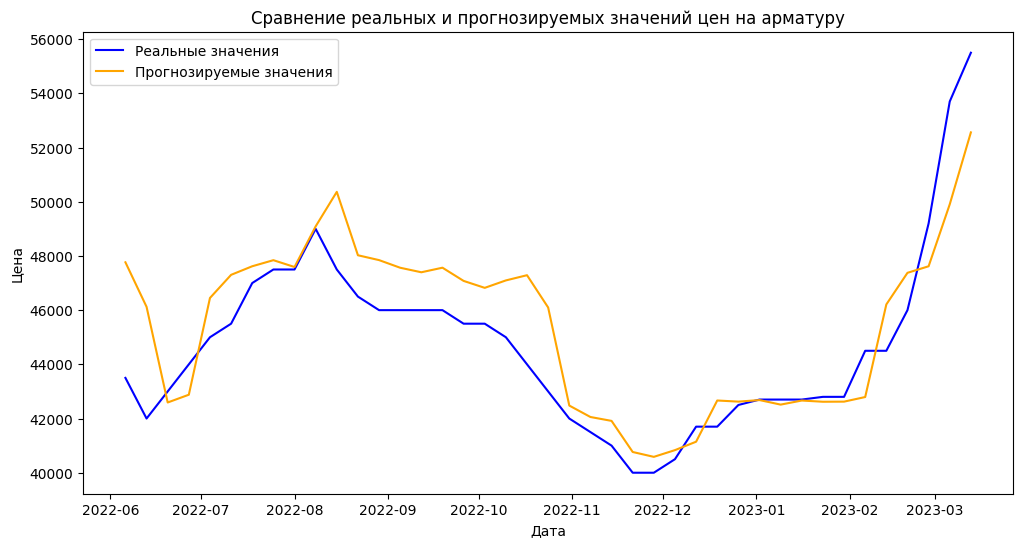

=== Metrics ===
MAE: 1352.52
MSE: 3155778.49
RMSE: 1776.45
R²: 0.70
=== Проверка на переобучение ===
Средний MAE по кросс-валидации (обучающая выборка): 4383.21
MAE на обучающей выборке: 357.18
Модель может быть переобучена.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Загрузка данных из файлов Excel
train_df = pd.read_excel('train.xlsx', parse_dates=['dt'])
test_df = pd.read_excel('test.xlsx', parse_dates=['dt'])

# Объединение данных
data = pd.concat([train_df, test_df], ignore_index=True)

# Разделение на обучающую и тестовую выборки (90% - 10%)
train_data, test_data = train_test_split(data, test_size=0.1, shuffle=False)

# Функция для создания новых признаков
def create_features(df):
    df['year'] = df['dt'].dt.year
    df['month'] = df['dt'].dt.month
    df['day'] = df['dt'].dt.day
    df['dayofweek'] = df['dt'].dt.dayofweek
    df['lag_1'] = df['Цена на арматуру'].shift(1)
    df['lag_2'] = df['Цена на арматуру'].shift(2)
    df['rolling_mean_3'] = df['Цена на арматуру'].rolling(window=3).mean()
    return df

# Применение функции к данным
train_data = create_features(train_data)
test_data = create_features(test_data)

# Удаляем строки с NaN значениями, которые появились из-за лагов
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

# Определение признаков и целевой переменной
X_train = train_data[['year', 'month', 'day', 'dayofweek', 'lag_1', 'lag_2', 'rolling_mean_3']]
y_train = train_data['Цена на арматуру']
X_test = test_data[['year', 'month', 'day', 'dayofweek', 'lag_1', 'lag_2', 'rolling_mean_3']]
y_test = test_data['Цена на арматуру']

# Обучение модели
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Прогнозирование
y_pred = model.predict(X_test)

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(test_data['dt'], y_test, label='Реальные значения', color='blue')
plt.plot(test_data['dt'], y_pred, label='Прогнозируемые значения', color='orange')
plt.title('Сравнение реальных и прогнозируемых значений цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()

# Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод метрик
print("=== Metrics ===")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# Оценка модели с использованием кросс-валидации
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

# Преобразование отрицательных значений в положительные
cv_scores = -cv_scores

# Среднее значение MAE по кросс-валидации
mean_cv_mae = np.mean(cv_scores)

# Оценка на обучающей выборке
train_preds = model.predict(X_train)
train_mae = mean_absolute_error(y_train, train_preds)

# Вывод результатов проверки на переобучение
print('=== Проверка на переобучение ===')
print(f'Средний MAE по кросс-валидации (обучающая выборка): {mean_cv_mae:.2f}')
print(f'MAE на обучающей выборке: {train_mae:.2f}')

# Проверка на переобучение
if train_mae < mean_cv_mae:
    print("Модель может быть переобучена.")
else:
    print("Модель не показывает признаков переобучения.")



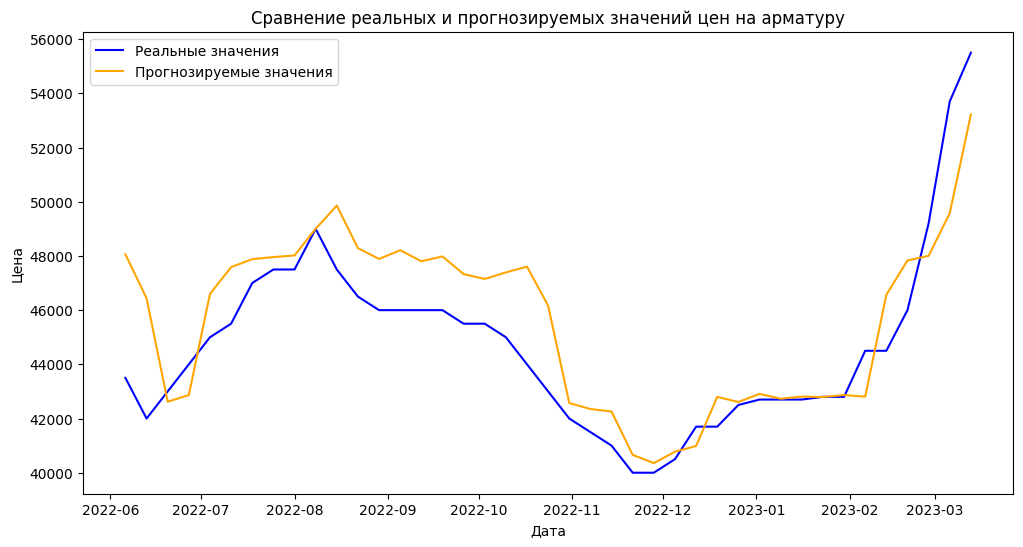

=== Metrics ===
MAE: 1469.25
MSE: 3620581.28
RMSE: 1902.78
R²: 0.65
=== Проверка на переобучение ===
Средний MAE по кросс-валидации (обучающая выборка): 4211.23
MAE на обучающей выборке: 452.24
Модель может быть переобучена.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Загрузка данных из файлов Excel
train_df = pd.read_excel('train.xlsx', parse_dates=['dt'])
test_df = pd.read_excel('test.xlsx', parse_dates=['dt'])

# Объединение данных
data = pd.concat([train_df, test_df], ignore_index=True)

# Разделение на обучающую и тестовую выборки (90% - 10%)
train_data, test_data = train_test_split(data, test_size=0.1, shuffle=False)

# Функция для создания новых признаков
def create_features(df):
    df['year'] = df['dt'].dt.year
    df['month'] = df['dt'].dt.month
    df['day'] = df['dt'].dt.day
    df['dayofweek'] = df['dt'].dt.dayofweek
    df['lag_1'] = df['Цена на арматуру'].shift(1)
    df['lag_2'] = df['Цена на арматуру'].shift(2)
    df['rolling_mean_3'] = df['Цена на арматуру'].rolling(window=3).mean()
    return df

# Применение функции к данным
train_data = create_features(train_data)
test_data = create_features(test_data)

# Удаляем строки с NaN значениями, которые появились из-за лагов
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

# Определение признаков и целевой переменной
X_train = train_data[['year', 'month', 'day', 'dayofweek', 'lag_1', 'lag_2', 'rolling_mean_3']]
y_train = train_data['Цена на арматуру']
X_test = test_data[['year', 'month', 'day', 'dayofweek', 'lag_1', 'lag_2', 'rolling_mean_3']]
y_test = test_data['Цена на арматуру']

# Обучение модели с уменьшенной сложностью
model = RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_split=5, random_state=42)
model.fit(X_train, y_train)

# Прогнозирование
y_pred = model.predict(X_test)

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(test_data['dt'], y_test, label='Реальные значения', color='blue')
plt.plot(test_data['dt'], y_pred, label='Прогнозируемые значения', color='orange')
plt.title('Сравнение реальных и прогнозируемых значений цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()

# Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод метрик
print("=== Metrics ===")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# Оценка модели с использованием кросс-валидации
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

# Преобразование отрицательных значений в положительные
cv_scores = -cv_scores

# Среднее значение MAE по кросс-валидации
mean_cv_mae = np.mean(cv_scores)

# Оценка на обучающей выборке
train_preds = model.predict(X_train)
train_mae = mean_absolute_error(y_train, train_preds)

# Вывод результатов проверки на переобучение
print('=== Проверка на переобучение ===')
print(f'Средний MAE по кросс-валидации (обучающая выборка): {mean_cv_mae:.2f}')
print(f'MAE на обучающей выборке: {train_mae:.2f}')

# Проверка на переобучение
if train_mae < mean_cv_mae:
    print("Модель может быть переобучена.")
else:
    print("Модель не показывает признаков переобучения.")


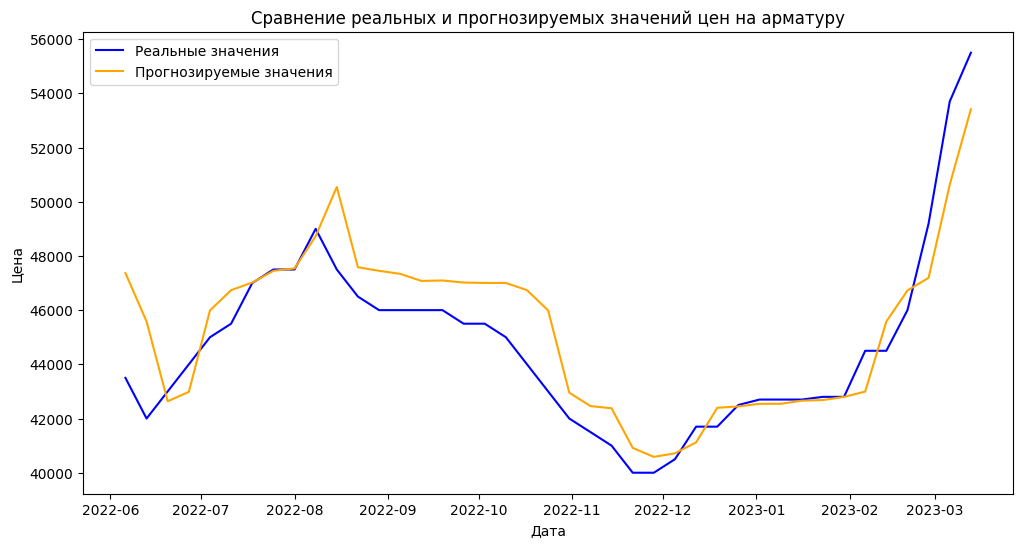

=== Metrics ===
MAE: 1184.54
MSE: 2460109.97
RMSE: 1568.47
R²: 0.77
=== Проверка на переобучение ===
Средний MAE по кросс-валидации (обучающая выборка): 4844.50
MAE на обучающей выборке: 683.37
Модель может быть переобучена.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Загрузка данных из файлов Excel
train_df = pd.read_excel('train.xlsx', parse_dates=['dt'])
test_df = pd.read_excel('test.xlsx', parse_dates=['dt'])

# Объединение данных
data = pd.concat([train_df, test_df], ignore_index=True)

# Разделение на обучающую и тестовую выборки (90% - 10%)
train_data, test_data = train_test_split(data, test_size=0.1, shuffle=False)

# Функция для создания новых признаков
def create_features(df):
    df['year'] = df['dt'].dt.year
    df['month'] = df['dt'].dt.month
    df['day'] = df['dt'].dt.day
    df['dayofweek'] = df['dt'].dt.dayofweek
    df['lag_1'] = df['Цена на арматуру'].shift(1)
    df['lag_2'] = df['Цена на арматуру'].shift(2)
    df['rolling_mean_3'] = df['Цена на арматуру'].rolling(window=3).mean()
    return df

# Применение функции к данным
train_data = create_features(train_data)
test_data = create_features(test_data)

# Удаляем строки с NaN значениями, которые появились из-за лагов
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

# Определение признаков и целевой переменной
X_train = train_data[['year', 'month', 'day', 'dayofweek', 'lag_1', 'lag_2', 'rolling_mean_3']]
y_train = train_data['Цена на арматуру']
X_test = test_data[['year', 'month', 'day', 'dayofweek', 'lag_1', 'lag_2', 'rolling_mean_3']]
y_test = test_data['Цена на арматуру']

# Обучение модели с измененными параметрами для снижения риска переобучения
model = RandomForestRegressor(
    n_estimators=100,        # Увеличиваем количество деревьев
    max_depth=8,             # Уменьшаем максимальную глубину деревьев
    min_samples_split=10,    # Увеличиваем минимальное количество образцов для разбиения узла
    min_samples_leaf=5,      # Увеличиваем минимальное количество образцов в листе
    random_state=42,
    bootstrap=True            # Используем бутстрэп для повышения устойчивости
)

model.fit(X_train, y_train)

# Прогнозирование
y_pred = model.predict(X_test)

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(test_data['dt'], y_test, label='Реальные значения', color='blue')
plt.plot(test_data['dt'], y_pred, label='Прогнозируемые значения', color='orange')
plt.title('Сравнение реальных и прогнозируемых значений цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()

# Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод метрик
print("=== Metrics ===")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# Оценка модели с использованием кросс-валидации
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

# Преобразование отрицательных значений в положительные
cv_scores = -cv_scores

# Среднее значение MAE по кросс-валидации
mean_cv_mae = np.mean(cv_scores)

# Оценка на обучающей выборке
train_preds = model.predict(X_train)
train_mae = mean_absolute_error(y_train, train_preds)

# Вывод результатов проверки на переобучение
# Вывод результатов проверки на переобучение
print('=== Проверка на переобучение ===')
print(f'Средний MAE по кросс-валидации (обучающая выборка): {mean_cv_mae:.2f}')
print(f'MAE на обучающей выборке: {train_mae:.2f}')

# Проверка на переобучение
if train_mae < mean_cv_mae:
    print("Модель может быть переобучена.")
else:
    print("Модель не показывает признаков переобучения.")

Средний MAE кросс-валидации: 1531.22


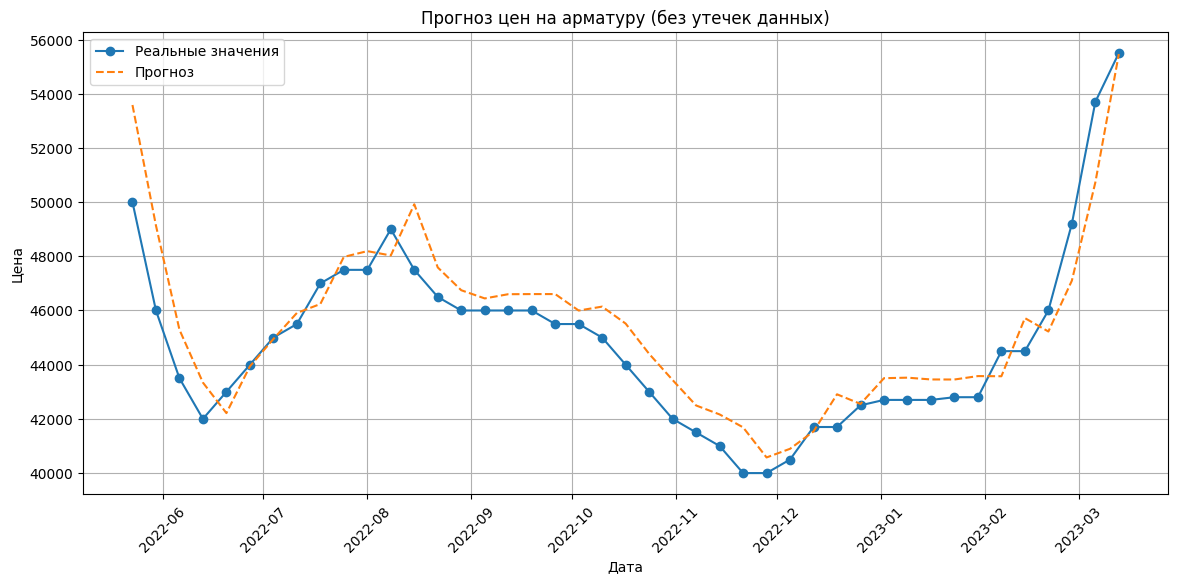


=== Метрики на тесте ===
MAE: 1049.91
RMSE: 1317.05
R²: 0.84

=== Проверка на переобучение ===
MAE на трейне: 843.70
MAE на тесте: 1049.91
Модель может быть переобучена: MAE на трейне меньше MAE на тесте.


In [ ]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Загрузка данных с правильной сортировкой по дате
train_df = pd.read_excel('train.xlsx', parse_dates=['dt']).sort_values('dt')
test_df = pd.read_excel('test.xlsx', parse_dates=['dt']).sort_values('dt')

# Объединение данных с сохранением временного порядка
full_df = pd.concat([train_df, test_df]).sort_values('dt').reset_index(drop=True)

# Функция для создания временных признаков БЕЗ УТЕЧЕК
def create_features(df):
    df = df.copy()
    
    # Временные компоненты
    df['year'] = df['dt'].dt.year
    df['month'] = df['dt'].dt.month
    df['dayofweek'] = df['dt'].dt.dayofweek
    
    # Лаги с защитой от утечек
    df['lag_1'] = df['Цена на арматуру'].shift(1)
    df['lag_2'] = df['Цена на арматуру'].shift(2)
    
    # Скользящее среднее с защитой от утечек
    df['rolling_mean_3'] = df['Цена на арматуру'].shift(1).rolling(window=3).mean()
    
    return df.dropna()

# Применение функций к данным
full_df = create_features(full_df)

# Разделение на трейн/тест БЕЗ ПЕРЕМЕШИВАНИЯ
split_idx = int(len(full_df)*0.9)
train_data = full_df.iloc[:split_idx]
test_data = full_df.iloc[split_idx:]

# Выбор фичей и таргета
features = ['year', 'month', 'dayofweek', 'lag_1', 'lag_2', 'rolling_mean_3']
target = 'Цена на арматуру'

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение модели с кросс-валидацией
tscv = TimeSeriesSplit(n_splits=3)
model = Ridge(alpha=1.0)

# Проверка на переобучение
cv_scores = -cross_val_score(model, X_train_scaled, y_train, 
                           cv=tscv, scoring='neg_mean_absolute_error')
print(f"Средний MAE кросс-валидации: {np.mean(cv_scores):.2f}")

# Финальное обучение
model.fit(X_train_scaled, y_train)

# Прогнозирование
test_preds = model.predict(X_test_scaled)
train_preds = model.predict(X_train_scaled)

# Визуализация
plt.figure(figsize=(14, 6))
plt.plot(test_data['dt'], y_test, label='Реальные значения', marker='o')
plt.plot(test_data['dt'], test_preds, label='Прогноз', linestyle='--')
plt.title('Прогноз цен на арматуру (без утечек данных)')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Метрики
print("\n=== Метрики на тесте ===")
print(f"MAE: {mean_absolute_error(y_test, test_preds):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, test_preds)):.2f}")
print(f"R²: {r2_score(y_test, test_preds):.2f}")

print("\n=== Проверка на переобучение ===")
mae_train = mean_absolute_error(y_train, train_preds)
mae_test = mean_absolute_error(y_test, test_preds)

print(f"MAE на трейне: {mae_train:.2f}")
print(f"MAE на тесте: {mae_test:.2f}")

# Проверка на переобучение через разницу в MAE
if mae_train < mae_test:
    print("Модель может быть переобучена: MAE на трейне меньше MAE на тесте.")
else:
    print("Модель не переобучена: MAE на трейне не меньше MAE на тесте.")

